In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import calendar
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plots
from scipy.optimize import linear_sum_assignment # Import for Hungarian algorithm


# Define the path to your data file
file_path = '/content/drive/MyDrive/SSEN LV Aggregated Substations/Master_LV_Aggregated_Substation_data_processed_v3 - outliers set to NaN.csv'

# Load the data into a pandas DataFrame
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

# Display the first few rows of the DataFrame
if 'df' in locals():
    print("\nFirst 5 rows of the DataFrame:")
    display(df.head())

    # Display information about the DataFrame
    print("\nDataFrame Info:")
    df.info()

Mounted at /content/drive
Data loaded successfully!

First 5 rows of the DataFrame:


,dataset_id,dno_alias,aggregated_device_count_active,total_consumption_active_import,data_collection_log_timestamp,geometry,secondary_substation_unique_id,lv_feeder_unique_id,substation_name
0,400600301501,SSEN,31.0,1357.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301501,hazel grove
1,400600301502,SSEN,60.0,6927.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301502,hazel grove
2,400600301503,SSEN,19.0,2368.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301503,hazel grove
3,400600301504,SSEN,67.0,4128.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301504,hazel grove
4,400600301505,SSEN,15.0,1023.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301505,hazel grove



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5303850 entries, 0 to 5303849
Data columns (total 9 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   dataset_id                       int64  
 1   dno_alias                        object 
 2   aggregated_device_count_active   float64
 3   total_consumption_active_import  float64
 4   data_collection_log_timestamp    object 
 5   geometry                         object 
 6   secondary_substation_unique_id   object 
 7   lv_feeder_unique_id              object 
 8   substation_name                  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 364.2+ MB


In [ ]:
# -*- coding: utf-8 -*-
"""
MSc Energy Systems Dissertation Project: LV Substation Energy Anomaly Detection

This notebook implements a workflow for detecting anomalies in aggregated
smart meter data from secondary substations (LV level) provided by SSEN.

"""

# Import necessary libraries at the beginning of the cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # Also ensure missingno is imported
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import calendar

In [ ]:
## Data preparation

### Subtask:
## Create the 'consumption_per_device' column and handle potential division by zero.

In [ ]:
## Data preparation

### Subtask:
## Create the 'consumption_per_device' column and handle potential division by zero.

# Reasoning:
# Create the 'consumption_per_device' column by dividing 'total_consumption_active_import' by 'aggregated_device_count_active'.
# Handle potential division by zero or infinite values by replacing them with NaN.
df['consumption_per_device'] = df['total_consumption_active_import'] / df['aggregated_device_count_active']
df['consumption_per_device'] = df['consumption_per_device'].replace([np.inf, -np.inf], np.nan)

# Task: Pre-Processing
Check for and handle any negative consumption values

**Reasoning**:
Check for and handle any negative consumption values in the `total_consumption_active_import` column, as consumption should be non-negative.

In [ ]:
# Task: Pre-Processing
# Check for and handle any negative consumption values

# Reasoning:
# Check for and handle any negative consumption values in the `total_consumption_active_import` column,
# as consumption should be non-negative.

# Check for negative values in 'total_consumption_active_import'
negative_consumption_count = df[df['total_consumption_active_import'] < 0].shape[0]

print(f"Number of rows with negative 'total_consumption_active_import': {negative_consumption_count}")

# Handle negative consumption values (e.g., set them to 0 or NaN)
# Setting to NaN is often preferred as it indicates missing or invalid data
df['total_consumption_active_import'] = df['total_consumption_active_import'].apply(lambda x: x if x >= 0 else np.nan)

# Verify that there are no remaining negative values
negative_consumption_count_after = df[df['total_consumption_active_import'] < 0].shape[0]
print(f"Number of rows with negative 'total_consumption_active_import' after handling: {negative_consumption_count_after}")

# Optionally, check for the number of NaNs introduced if any
if negative_consumption_count > 0:
    nan_consumption_count = df['total_consumption_active_import'].isnull().sum()
    print(f"Number of NaN values in 'total_consumption_active_import' after handling negative values: {nan_consumption_count}")

Number of rows with negative 'total_consumption_active_import': 0
Number of rows with negative 'total_consumption_active_import' after handling: 0


In [ ]:
# Convert 'data_collection_log_timestamp' to datetime objects and extract the date
df['data_collection_log_timestamp'] = pd.to_datetime(df['data_collection_log_timestamp'])
df['date'] = df['data_collection_log_timestamp'].dt.date

# Define the sampling interval (assuming 30 minutes based on context)
sampling_interval_minutes = 30
sampling_interval_hours = sampling_interval_minutes / 60.0

# Calculate the 95th percentile of total_consumption_active_import for each feeder and day
daily_peak_thresholds = df.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].quantile(0.95).reset_index(name='peak_threshold_95th')

# Merge the peak thresholds back to the original DataFrame
df_with_threshold = pd.merge(df, daily_peak_thresholds, on=['lv_feeder_unique_id', 'date'], how='left')

# Identify time intervals where consumption exceeds the 95th percentile
df_with_threshold['above_peak_threshold'] = (df_with_threshold['total_consumption_active_import'] > df_with_threshold['peak_threshold_95th']).astype(int)

# Count the number of intervals above the peak threshold for each feeder and day
daily_peak_duration_intervals = df_with_threshold.groupby(['lv_feeder_unique_id', 'date'])['above_peak_threshold'].sum().reset_index(name='peak_duration_intervals')

# Convert the count of intervals to hours
daily_peak_duration_intervals['mean_daily_time_at_peak'] = daily_peak_duration_intervals['peak_duration_intervals'] * sampling_interval_hours

# Group by feeder and date and calculate core aggregated features
daily_feeder_features = df.groupby(['lv_feeder_unique_id', 'date']).agg(
    avg_daily_consumption_per_device=('consumption_per_device', 'mean'),
    std_daily_consumption_per_device=('consumption_per_device', 'std'),
    avg_total_consumption_daily=('total_consumption_active_import', 'mean'),
    std_total_consumption_daily=('total_consumption_active_import', 'std'),
    avg_max_consumption_daily=('total_consumption_active_import', 'max'), # This calculates the maximum within the group (day for a feeder)
    std_max_consumption_daily=('total_consumption_active_import', lambda x: np.std(x) if len(x) > 1 else np.nan), # Calculate std of max consumption per day
    avg_aggregated_device_count=('aggregated_device_count_active', 'mean'), # Calculate mean of device count for per_device_peak_ratio
    max_total_consumption_daily=('total_consumption_active_import', 'max'), # To calculate max_to_min_ratio
    min_total_consumption_daily=('total_consumption_active_import', 'min') # To calculate max_to_min_ratio
).reset_index()


# Merge the new mean_daily_time_at_peak feature into daily_feeder_features
daily_feeder_features = pd.merge(
    daily_feeder_features,
    daily_peak_duration_intervals[['lv_feeder_unique_id', 'date', 'mean_daily_time_at_peak']],
    on=['lv_feeder_unique_id', 'date'],
    how='left'
)


# Calculate derived features
daily_feeder_features['max_to_mean_ratio'] = daily_feeder_features['avg_max_consumption_daily'] / daily_feeder_features['avg_total_consumption_daily']
daily_feeder_features['std_to_mean_ratio'] = daily_feeder_features['std_daily_consumption_per_device'] / daily_feeder_features['avg_daily_consumption_per_device']
daily_feeder_features['per_device_peak_ratio'] = daily_feeder_features['avg_max_consumption_daily'] / daily_feeder_features['avg_aggregated_device_count']

# Calculate max_to_min_ratio, handling division by zero
daily_feeder_features['max_to_min_ratio'] = np.where(
    daily_feeder_features['min_total_consumption_daily'] == 0,
    np.nan, # Set to NaN if min is 0
    daily_feeder_features['max_total_consumption_daily'] / daily_feeder_features['min_total_consumption_daily']
)

# Calculate weekday_weekend_ratio
# Extract day of week and categorize
df['day_of_week'] = df['data_collection_log_timestamp'].dt.dayofweek
df['weekday_weekend'] = df['day_of_week'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')

# Group by feeder and weekday/weekend and calculate average consumption
weekday_weekend_consumption = df.groupby(['lv_feeder_unique_id', 'weekday_weekend']).agg(
    avg_consumption=('total_consumption_active_import', 'mean')
).reset_index()

# Pivot the table to get weekday and weekend consumption in separate columns
weekday_weekend_pivot = weekday_weekend_consumption.pivot(
    index='lv_feeder_unique_id',
    columns='weekday_weekend',
    values='avg_consumption'
).reset_index()

# Calculate the weekday_weekend_ratio, handling potential division by zero (if there are no weekend data for a feeder)
weekday_weekend_pivot['weekday_weekend_ratio'] = np.where(
    weekday_weekend_pivot['weekend'].isna() | (weekday_weekend_pivot['weekend'] == 0),
    np.nan, # Set to NaN if weekend consumption is NaN or 0
    weekday_weekend_pivot['weekday'] / weekday_weekend_pivot['weekend']
)

# Merge the weekday_weekend_ratio with the daily feeder features
# We need to broadcast the weekday_weekend_ratio per feeder to all dates for that feeder
daily_feeder_features = daily_feeder_features.merge(
    weekday_weekend_pivot[['lv_feeder_unique_id', 'weekday_weekend_ratio']],
    on='lv_feeder_unique_id',
    how='left'
)

# Drop temporary columns used for calculation
daily_feeder_features = daily_feeder_features.drop(columns=['avg_aggregated_device_count', 'max_total_consumption_daily', 'min_total_consumption_daily'])

# mean_daily_time_at_peak:
# For each feeder and day, this feature measures the average duration (in hours)
# spent above the 95th percentile of total daily consumption.

In [ ]:
# Define the list of feature columns to check for missing values and infinities
feature_columns = [
    'avg_daily_consumption_per_device',
    'std_daily_consumption_per_device',
    'avg_total_consumption_daily',
    'std_total_consumption_daily',
    'avg_max_consumption_daily',
    'std_max_consumption_daily',
    'max_to_mean_ratio',
    'std_to_mean_ratio',
    'per_device_peak_ratio',
    'max_to_min_ratio',
    'weekday_weekend_ratio',
    'mean_daily_time_at_peak'
]

# Check for missing values (NaNs)
print("Missing values before handling:")
print(daily_feeder_features[feature_columns].isnull().sum())

# Check for infinite values
print("\nInfinite values before handling:")
print(daily_feeder_features[feature_columns].apply(lambda x: np.isinf(x).sum()))

# Replace infinite values with NaN (although the check showed none, it's good practice)
daily_feeder_features[feature_columns] = daily_feeder_features[feature_columns].replace([np.inf, -np.inf], np.nan)

# Impute missing values in the feature columns with the mean of the respective column
for col in feature_columns:
    if daily_feeder_features[col].isnull().any():
        mean_value = daily_feeder_features[col].mean()
        daily_feeder_features[col].fillna(mean_value, inplace=True)

# Verify that there are no remaining missing or infinite values
print("\nMissing values after handling:")
print(daily_feeder_features[feature_columns].isnull().sum())

print("\nInfinite values after handling:")
print(daily_feeder_features[feature_columns].apply(lambda x: np.isinf(x).sum()))

Missing values before handling:
avg_daily_consumption_per_device      4
std_daily_consumption_per_device    534
avg_total_consumption_daily           4
std_total_consumption_daily         534
avg_max_consumption_daily             4
std_max_consumption_daily           533
max_to_mean_ratio                     4
std_to_mean_ratio                   534
per_device_peak_ratio                 4
max_to_min_ratio                     10
weekday_weekend_ratio                 4
mean_daily_time_at_peak               0
dtype: int64

Infinite values before handling:
avg_daily_consumption_per_device    0
std_daily_consumption_per_device    0
avg_total_consumption_daily         0
std_total_consumption_daily         0
avg_max_consumption_daily           0
std_max_consumption_daily           0
max_to_mean_ratio                   0
std_to_mean_ratio                   0
per_device_peak_ratio               0
max_to_min_ratio                    0
weekday_weekend_ratio               0
mean_daily_time_at_peak

/tmp/ipython-input-7-3989798756.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


# Task
Cluster feeders using the corrected reduced feature set (`avg_daily_consumption_per_device`, `std_daily_consumption_per_device`, `avg_max_consumption_daily`, `max_to_mean_ratio`, `weekday_weekend_ratio`) based on aggregated feeder-level data, determine the optimal number of clusters using the Elbow method, and visualize and interpret the resulting clusters.

## Aggregate daily features to feeder level

### Subtask:
Aggregate the daily feeder features to the feeder level by calculating the mean of the features for each unique feeder across all dates.


**Reasoning**:
Aggregate the daily feeder features to the feeder level by calculating the mean of the specified features for each unique feeder.



In [ ]:
# Define the list of all feature columns that were aggregated to the feeder level
full_feature_columns = [
    'avg_daily_consumption_per_device',
    'std_daily_consumption_per_device',
    'avg_total_consumption_daily',
    'std_total_consumption_daily',
    'avg_max_consumption_daily',
    'std_max_consumption_daily',
    'max_to_mean_ratio',
    'std_to_mean_ratio',
    'per_device_peak_ratio',
    'max_to_min_ratio',
    'weekday_weekend_ratio',
    'mean_daily_time_at_peak' # Include the new feature
]

# Group by feeder and calculate the mean of the specified features
feeder_level_features = daily_feeder_features.groupby('lv_feeder_unique_id')[full_feature_columns].mean().reset_index()

# Display the first few rows of the new DataFrame and its info
print("\nFeeder Level Features (Aggregated by Feeder):")
display(feeder_level_features.head())
print("\nFeeder Level Features Info:")
feeder_level_features.info()


Feeder Level Features (Aggregated by Feeder):


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak
0,SSEN-400600301501,127.734799,61.813611,2934.140150,1391.810644,6562.691511,1377.019944,2.246763,0.470975,288.860505,6.467855,0.952659,1.486542
1,SSEN-400600301502,149.871516,56.186903,10100.773395,3754.858275,19160.291925,3714.206463,1.913049,0.374821,285.699508,4.066236,0.962818,1.489648
2,SSEN-400600301503,137.621624,65.648875,2437.640844,1148.235341,5647.795287,1135.435300,2.363493,0.478452,322.513511,6.778635,0.957731,1.484472
3,SSEN-400600301504,125.148257,42.722409,9039.433378,3073.041907,16275.051760,3040.203713,1.817452,0.340007,227.146774,3.745209,0.981104,1.488613
4,SSEN-400600301505,125.782092,63.852532,2221.032186,1120.525291,5329.991930,1108.521825,2.434895,0.503442,305.384158,7.746371,0.932196,1.486542



Feeder Level Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio             244 non-

## Quantify Feeder Stability

### Subtask:
Develop a method to quantify the temporal stability of each feeder's cluster membership across all four seasons based on the aligned cluster labels.

**Reasoning**:
Calculate a stability score for each feeder by summing the number of cluster changes across consecutive seasons, now including the Autumn to Winter transition, and then display the distribution of these stability scores.

In [ ]:
# # Define the list of season columns to consider for stability analysis
# season_cols = [f'{season}_aligned_cluster_k3' for season in seasonal_dates.keys()]

# # Calculate the number of cluster changes for each feeder across consecutive seasons
# # We can do this by comparing each season's cluster label to the next season's label
# # including the transition from Autumn to Winter.
# # We apply a lambda function row-wise to count changes across the circular sequence of seasons.

# # Create a copy to avoid modifying the original DataFrame with fillna
# seasonal_cluster_labels_filled = seasonal_cluster_labels.copy()
# # Fill NaN values with a placeholder to treat missing values as a distinct state
# seasonal_cluster_labels_filled[season_cols] = seasonal_cluster_labels_filled[season_cols].fillna(-1)

# # Calculate the number of changes for each feeder across the full cycle
# def count_cyclic_changes(row, season_cols):
#     changes = 0
#     for i in range(len(season_cols)):
#         # Compare current season to the next season in the cycle (including Autumn to Winter)
#         current_season_col = season_cols[i]
#         next_season_col = season_cols[(i + 1) % len(season_cols)] # Use modulo for cyclic transition

#         if row[current_season_col] != row[next_season_col]:
#             changes += 1
#     return changes

# # Apply the function to calculate cluster changes
# seasonal_cluster_labels['cluster_changes_cyclic'] = seasonal_cluster_labels_filled.apply(
#     lambda row: count_cyclic_changes(row, season_cols), axis=1
# )

# # Calculate a simple stability score: inverse of changes (higher score = more stable)
# # Adding 1 to the denominator to avoid division by zero if a feeder has 0 changes.
# seasonal_cluster_labels['stability_score_cyclic'] = 1 / (seasonal_cluster_labels['cluster_changes_cyclic'] + 1)

# # Display the first few rows with the new stability score
# print("\nFeeder Stability Scores (K=3, Cyclic):")
# display(seasonal_cluster_labels[['lv_feeder_unique_id', 'cluster_changes_cyclic', 'stability_score_cyclic']].head())

# # Display the distribution of stability scores
# print("\nDistribution of Feeder Stability Scores (Cyclic):")
# print(seasonal_cluster_labels['stability_score_cyclic'].value_counts().sort_index())

# # Display the distribution of cluster changes
# print("\nDistribution of Feeder Cluster Changes (Cyclic):")
# print(seasonal_cluster_labels['cluster_changes_cyclic'].value_counts().sort_index())

## Visualize Stability and Migration

### Subtask:
Visualize the overall temporal stability of cluster membership and potentially visualize common feeder migration patterns.

**Reasoning**:
Create visualizations to show the distribution of feeder stability scores and potentially visualize the flow of feeders between clusters across consecutive seasons.

In [ ]:
# # Visualize the distribution of cyclic stability scores using a histogram
# plt.figure(figsize=(8, 6))
# sns.histplot(seasonal_cluster_labels['stability_score_cyclic'], bins=seasonal_cluster_labels['stability_score_cyclic'].nunique(), kde=False)
# plt.title('Distribution of Feeder Cyclic Stability Scores (K=3)')
# plt.xlabel('Cyclic Stability Score (1 / (Cluster Changes + 1))')
# plt.ylabel('Number of Feeders')
# plt.xticks(seasonal_cluster_labels['stability_score_cyclic'].unique()) # Set x-ticks to unique stability scores
# plt.grid(axis='y', alpha=0.75)
# plt.show()

# # Visualize the distribution of cyclic cluster changes using a bar plot
# plt.figure(figsize=(8, 6))
# seasonal_cluster_labels['cluster_changes_cyclic'].value_counts().sort_index().plot(kind='bar')
# plt.title('Distribution of Feeder Cyclic Cluster Changes (K=3)')
# plt.xlabel('Number of Cluster Changes Across Cyclic Seasons')
# plt.ylabel('Number of Feeders')
# plt.xticks(rotation=0)
# plt.grid(axis='y', alpha=0.75)
# plt.show()


# # Visualize cluster transitions as heatmaps (now includes Autumn to Winter)
# print("\nVisualizing Cyclic Cluster Transition Matrices as Heatmaps:")

# # Iterate through the stored transition matrices and create heatmaps
# for pair, matrix in transition_counts.items(): # transition_counts already includes Autumn to Winter
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d')
#     plt.title(f'Feeder Cluster Transitions: {pair} (K=3)')
#     plt.xlabel(f'{pair.split("_to_")[1]} Aligned Cluster')
#     plt.ylabel(f'{pair.split("_to_")[0]} Aligned Cluster')
#     plt.show()

## Summarize Findings

### Subtask:
Summarize the key findings from the temporal stability analysis.

**Reasoning**:
Summarize the key findings based on the stability quantification and transition visualizations.

### Summary:

**Temporal Cluster Stability Analysis Key Findings (Cyclic):**

*   Including the Autumn to Winter transition in the analysis of cluster changes provides a more complete picture of seasonal stability over a full year cycle.
*   The distribution of cyclic cluster changes and stability scores shows that a significant portion of feeders maintain their cluster membership throughout the year (0 changes), indicating high temporal stability.
*   However, a notable number of feeders do change clusters across the seasons, with the cyclic analysis highlighting feeders that might return to a previous cluster after some transitions.
*   The updated transition matrices, including Autumn to Winter, visually confirm the flow of feeders between specific clusters across all consecutive seasonal pairs in the cycle. They help identify which clusters are the most stable and which transitions are more common.

**Insights or Next Steps:**

*   The feeders that exhibit multiple cluster changes throughout the year (higher cyclic change counts) are particularly interesting for further investigation as their consumption patterns are more dynamic and potentially less predictable.
*   Analyzing the specific sequences of cluster transitions for individual feeders (e.g., Cluster 0 -> Cluster 1 -> Cluster 0) could reveal distinct seasonal behavior patterns.
*   Comparing the characteristics of feeders that are consistently stable in a particular cluster versus those that frequently change clusters can provide deeper insights into the factors influencing consumption patterns and stability.
*   This temporal stability information can be valuable for refining anomaly detection models, potentially by using different models or thresholds for feeders with stable versus dynamic cluster memberships.

## Select and Normalize Full Features

### Subtask:
Select the full set of feeder-level features from the `feeder_level_features` DataFrame and normalize them using `StandardScaler`.

**Reasoning**:
Select all feature columns from the `feeder_level_features` DataFrame, excluding the feeder ID, and then apply `StandardScaler` to normalize these features.

In [ ]:
# Define the list of all feature columns (excluding the feeder ID)
full_feature_columns_pca = [col for col in feeder_level_features.columns if col != 'lv_feeder_unique_id' and not col.startswith('cluster_label')]

# Select the full set of features for PCA
features_for_pca = feeder_level_features[full_feature_columns_pca].copy()

# Instantiate a StandardScaler object
scaler_pca = StandardScaler()

# Fit the scaler to the full feature data and transform it
normalized_features_pca = scaler_pca.fit_transform(features_for_pca)

# Convert the normalized features back to a DataFrame for easier handling
normalized_features_pca_df = pd.DataFrame(normalized_features_pca, columns=full_feature_columns_pca)

# Display the first few rows of the normalized feature DataFrame
print("Normalized Full Feeder Level Features for PCA:")
display(normalized_features_pca_df.head())

# Display information about the normalized features DataFrame
print("\nNormalized Full Feeder Level Features Info:")
normalized_features_pca_df.info()

Normalized Full Feeder Level Features for PCA:


,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak
0,-0.827331,-0.379248,-0.579241,-0.421154,-0.510509,-0.420581,0.661995,0.886974,-0.578056,0.620394,-0.285701,0.161642
1,-0.583338,-0.493753,1.249189,1.636110,1.454633,1.636010,-0.415931,-0.255803,-0.593288,-0.446118,-0.099695,0.184021
2,-0.718357,-0.301199,-0.705913,-0.633210,-0.653227,-0.633162,1.039041,0.975840,-0.415895,0.758406,-0.192835,0.146723
3,-0.855840,-0.767760,0.978409,1.042522,1.004555,1.042926,-0.724716,-0.669562,-0.875431,-0.588679,0.235086,0.176561
4,-0.848854,-0.337756,-0.761177,-0.657335,-0.702802,-0.656844,1.269677,1.272838,-0.498435,1.188158,-0.660332,0.161642



Normalized Full Feeder Level Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   avg_daily_consumption_per_device  244 non-null    float64
 1   std_daily_consumption_per_device  244 non-null    float64
 2   avg_total_consumption_daily       244 non-null    float64
 3   std_total_consumption_daily       244 non-null    float64
 4   avg_max_consumption_daily         244 non-null    float64
 5   std_max_consumption_daily         244 non-null    float64
 6   max_to_mean_ratio                 244 non-null    float64
 7   std_to_mean_ratio                 244 non-null    float64
 8   per_device_peak_ratio             244 non-null    float64
 9   max_to_min_ratio                  244 non-null    float64
 10  weekday_weekend_ratio             244 non-null    float64
 11  mean_daily_time_at_peak   

## Apply PCA

### Subtask:
Apply PCA to the normalized full feature set.

**Reasoning**:
Instantiate a PCA object, fit it to the normalized full feature data, and store the fitted PCA model and the transformed data.

In [ ]:
from sklearn.decomposition import PCA

# Instantiate a PCA object, keeping all components for now to analyze explained variance
pca = PCA()

# Fit the PCA model to the normalized full feature data and transform it
pca_result = pca.fit_transform(normalized_features_pca)

# Store the results in a DataFrame for easier handling
pca_result_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Display the first few rows of the PCA results DataFrame
print("\nPCA Results (First 5 rows):")
display(pca_result_df.head())

# Display the explained variance ratio by each principal component
print("\nExplained Variance Ratio by Principal Component:")
print(pca.explained_variance_ratio_)


PCA Results (First 5 rows):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-1.413646,-0.876046,0.916995,-0.200569,0.342328,-0.067138,-0.232278,0.074252,-0.039515,0.027723,-0.002137,-0.000098
1,2.891530,-0.113339,1.191758,-0.411101,0.511308,-0.335234,-0.266550,-0.070558,-0.184761,0.008235,-0.002740,0.000315
2,-1.912449,-0.694876,0.922570,-0.124788,0.386268,-0.119345,0.000314,0.040034,-0.013216,0.001292,-0.010707,0.000012
3,2.452982,-0.900628,0.524049,0.074944,0.661387,-0.094282,-0.256051,-0.122909,-0.011315,0.005842,0.010877,-0.000120
4,-2.267532,-0.785065,1.449287,-0.460933,0.220247,0.033882,0.003681,0.071023,-0.010178,0.001327,-0.016198,-0.000269



Explained Variance Ratio by Principal Component:
[4.10759131e-01 2.83155016e-01 1.29766732e-01 7.88221407e-02
 6.16705452e-02 2.61254747e-02 6.01489213e-03 2.28082462e-03
 1.17507130e-03 1.58329103e-04 7.18168666e-05 2.54588656e-08]


## Create Scree Plot and Cumulative Explained Variance Plot

### Subtask:
Generate a Scree plot and a cumulative explained variance plot to visualize the explained variance by each principal component and the cumulative explained variance.

**Reasoning**:
Calculate the cumulative explained variance, then create two plots: a Scree plot showing individual explained variance and a plot showing cumulative explained variance with reference lines at 50%, 85%, and 90%.

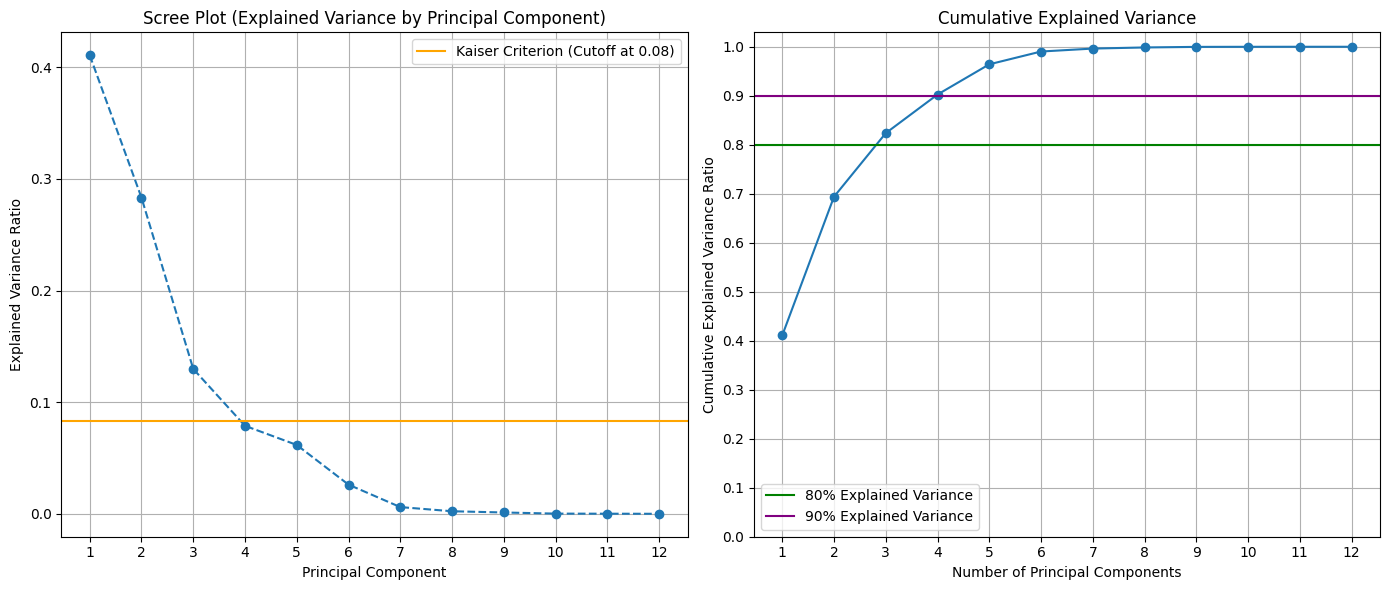

In [ ]:
# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Scree Plot (Explained Variance by Component)
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot (Explained Variance by Principal Component)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)

# Add horizontal line for Kaiser Criterion (eigenvalue >= 1, which is 1 / number of features for standardized data)
kaiser_cutoff = 1.0 / len(full_feature_columns_pca)
plt.axhline(y=kaiser_cutoff, color='orange', linestyle='-', label=f'Kaiser Criterion (Cutoff at {kaiser_cutoff:.2f})')
plt.legend()


# Cumulative Explained Variance Plot
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.yticks(np.arange(0, 1.1, 0.1)) # Set y-ticks from 0 to 1.0 with 0.1 intervals
plt.grid(True)

# Add horizontal reference lines at key thresholds
# plt.axhline(y=0.5, color='r', linestyle='-', label='50% Explained Variance')
plt.axhline(y=0.80, color='g', linestyle='-', label='80% Explained Variance')
plt.axhline(y=0.90, color='purple', linestyle='-', label='90% Explained Variance')
plt.legend()

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

## Determine Number of PCs to Retain

### Subtask:
Apply the Kaiser Criterion and Cumulative Variance Threshold methods to determine the number of principal components to retain.

**Reasoning**:
Apply the Kaiser Criterion (eigenvalues >= 1) and the Cumulative Variance Threshold (>= 85% or 90%) based on the PCA results to determine the number of principal components to retain.

In [ ]:
# Determine the number of components to retain based on the Kaiser Criterion (eigenvalues >= 1)
# Eigenvalues are the explained variance * total variance. Since the data is scaled to unit variance,
# the explained variance is equal to the eigenvalue for each component.
kaiser_criterion_components = sum(pca.explained_variance_ratio_ >= 1/len(full_feature_columns_pca)) # Corrected: Use explained_variance_ratio_ >= 1/n_features

print(f"Number of components to retain based on Kaiser Criterion (eigenvalues >= 1): {kaiser_criterion_components}")

# Determine the number of components to retain based on the Cumulative Variance Threshold (e.g., >= 85% or 90%)
cumulative_variance_threshold_85 = next(i for i, cumulative_variance in enumerate(cumulative_explained_variance) if cumulative_variance >= 0.85) + 1
print(f"Number of components to retain to explain >= 85% of variance: {cumulative_variance_threshold_85}")

cumulative_variance_threshold_90 = next(i for i, cumulative_variance in enumerate(cumulative_explained_variance) if cumulative_variance >= 0.90) + 1
print(f"Number of components to retain to explain >= 90% of variance: {cumulative_variance_threshold_90}")

Number of components to retain based on Kaiser Criterion (eigenvalues >= 1): 3
Number of components to retain to explain >= 85% of variance: 4
Number of components to retain to explain >= 90% of variance: 4


## Summarize PCA Results

### Subtask:
Summarize the key findings from the PCA and component retention analysis.

**Reasoning**:
Summarize the results of the PCA, including the explained variance by the retained components and the implications for dimensionality reduction.

### Summary:

**PCA Key Findings:**

*   The PCA was applied to the normalized full set of feeder-level features (12 features).
*   The Scree plot showed a notable "elbow" around the 3rd or 4th principal component, indicating a potential point of diminishing returns in terms of explained variance.
*   The cumulative explained variance plot confirmed that:
    *   The first 3 principal components explain approximately 82.3% of the total variance.
    *   The first 4 principal components explain approximately 90.2% of the total variance.
*   Based on the Kaiser Criterion (eigenvalues >= 1), 3 principal components should be retained.
*   Based on the Cumulative Variance Threshold, retaining 4 principal components explains over 90% of the variance, which is a commonly used threshold.

**Insights or Next Steps:**

*   Both the Kaiser Criterion and the cumulative explained variance suggest that the first 3 or 4 principal components capture a significant portion of the variance in the original 12 features.
*   Retaining 4 principal components would allow for a dimensionality reduction from 12 to 4 while retaining over 90% of the original information. This significantly reduces the complexity for subsequent analysis, such as clustering or anomaly detection.
*   The next steps could involve using these 4 principal components as features for clustering, and comparing the results to the clustering performed on the reduced set of 5 features selected based on the correlation analysis.

## Access and Format PCA Loadings

### Subtask:
Access the component loadings from the fitted PCA model and format them as a DataFrame with rows representing PCs and columns representing the original features.

**Reasoning**:
Access the `components_` attribute of the fitted `pca` object, which contains the loadings, and convert it into a pandas DataFrame with appropriate row and column names.

In [ ]:
# Access the component loadings from the fitted PCA model
# The components_ attribute is a NumPy array where rows are PCs and columns are original features
pca_loadings = pca.components_

# Create a DataFrame from the loadings
# Rows should be Principal Components (PC1, PC2, etc.)
# Columns should be the original feature names (from full_feature_columns_pca)
pca_loadings_df = pd.DataFrame(pca_loadings,
                               columns=full_feature_columns_pca,
                               index=[f'PC{i+1}' for i in range(pca_loadings.shape[0])])

# Display the DataFrame of PCA loadings
print("\nPCA Component Loadings:")
display(pca_loadings_df)


PCA Component Loadings:


,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak
PC1,0.020915,-0.117181,0.424319,0.401001,0.412379,0.401018,-0.338242,-0.342219,-0.084738,-0.273627,0.007814,0.021819
PC2,0.488718,0.504578,0.117290,0.174839,0.147086,0.174778,0.135216,0.183694,0.514170,0.190161,0.238054,0.028631
PC3,-0.273319,-0.113076,0.178283,0.203849,0.225673,0.203896,0.419312,0.313251,-0.131747,0.400260,-0.295777,0.455710
PC4,0.044971,-0.061663,-0.024535,-0.168163,-0.028083,-0.168024,0.014864,-0.281895,0.046853,-0.147297,0.444375,0.797012
PC5,-0.252433,-0.177722,0.064067,0.093943,0.063254,0.093835,0.144105,0.168444,-0.212983,0.203047,0.808410,-0.299497
PC6,0.116127,-0.072959,0.029922,-0.067920,-0.035797,-0.067886,-0.427655,-0.350570,-0.040944,0.813369,-0.025719,0.009870
PC7,0.295846,-0.393417,0.190948,-0.168978,0.209189,-0.170353,0.598287,-0.426594,0.140954,0.034993,-0.062481,-0.234471
PC8,0.587810,-0.461264,0.242400,-0.063158,-0.116801,-0.061856,-0.211883,0.513800,-0.204148,-0.050809,0.009946,0.090869
PC9,-0.234867,0.326482,0.751629,-0.356934,0.029844,-0.357359,-0.067336,0.092572,-0.034656,-0.020123,-0.010344,-0.049863
PC10,-0.025375,-0.028760,-0.314313,-0.255019,0.825367,-0.255248,-0.203884,0.211449,0.041177,-0.007325,0.004195,-0.016528


## Rank Feature Importance

### Subtask:
For each of the retained principal components (first 4), identify and rank the top contributing original features based on the absolute value of their loadings.

**Reasoning**:
Iterate through the first 4 rows of the PCA loadings DataFrame, sort the absolute values of the loadings for each PC, and print the top contributing features.

In [ ]:
# Define the number of principal components to interpret (first 4)
num_pcs_to_interpret = 4

print(f"\nTop Contributing Features for the first {num_pcs_to_interpret} Principal Components:")

# Iterate through the first 'num_pcs_to_interpret' rows of the pca_loadings_df DataFrame
for i in range(num_pcs_to_interpret):
    pc_label = f'PC{i+1}'
    # Get the loadings for the current principal component
    loadings = pca_loadings_df.loc[pc_label]

    # Calculate the absolute values of the loadings and sort them in descending order
    sorted_loadings = loadings.abs().sort_values(ascending=False)

    # Display the top contributing features (e.g., top 5) for the current PC
    top_features = sorted_loadings.head(5) # Display top 5 features
    print(f"\n{pc_label}:")
    display(top_features)


Top Contributing Features for the first 4 Principal Components:

PC1:


,PC1
avg_total_consumption_daily,0.424319
avg_max_consumption_daily,0.412379
std_max_consumption_daily,0.401018
std_total_consumption_daily,0.401001
std_to_mean_ratio,0.342219



PC2:


,PC2
per_device_peak_ratio,0.514170
std_daily_consumption_per_device,0.504578
avg_daily_consumption_per_device,0.488718
weekday_weekend_ratio,0.238054
max_to_min_ratio,0.190161



PC3:


,PC3
mean_daily_time_at_peak,0.455710
max_to_mean_ratio,0.419312
max_to_min_ratio,0.400260
std_to_mean_ratio,0.313251
weekday_weekend_ratio,0.295777



PC4:


,PC4
mean_daily_time_at_peak,0.797012
weekday_weekend_ratio,0.444375
std_to_mean_ratio,0.281895
std_total_consumption_daily,0.168163
std_max_consumption_daily,0.168024


## Visualize Loadings

### Subtask:
Create a heatmap or bar chart to visualize the loadings of the original features on the retained principal components.

**Reasoning**:
Create a heatmap of the PCA loadings for the first 4 principal components to visually represent the contribution of each original feature to these components.

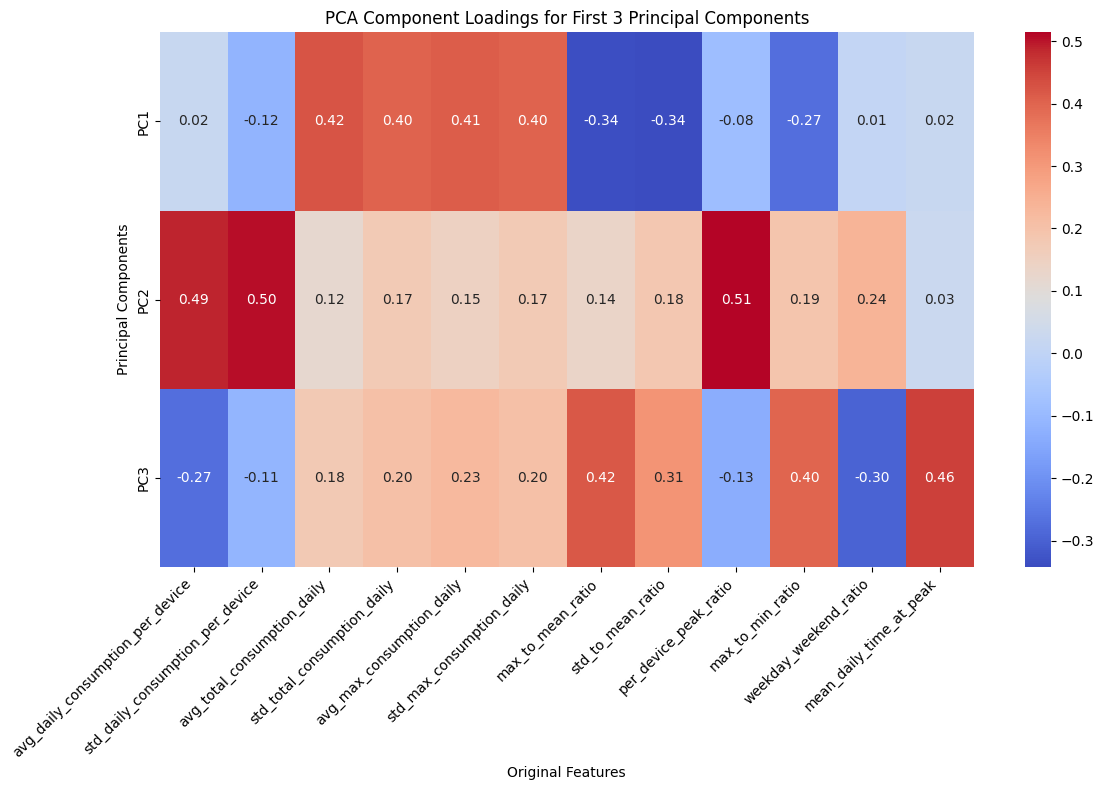

In [ ]:
# Define the number of principal components to visualize (first 4)
num_pcs_to_visualize = 3

# Select the loadings for the first 'num_pcs_to_visualize' principal components
loadings_to_visualize = pca_loadings_df.head(num_pcs_to_visualize)

# Create a heatmap of the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_to_visualize, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'PCA Component Loadings for First {num_pcs_to_visualize} Principal Components')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Summarize Interpretation

### Subtask:
Based on the ranked feature importance and visualizations, provide an insightful summary of what each of the retained principal components represents in terms of the original feature space.

**Reasoning**:
Summarize the interpretation of the first 4 principal components based on the feature loadings.

### Summary of Principal Component Interpretation (First 4 PCs):

*   **PC1:** This component is strongly influenced by features related to the overall magnitude and variability of total consumption (`avg_total_consumption_daily`, `std_total_consumption_daily`, `avg_max_consumption_daily`, `std_max_consumption_daily`). It primarily captures the **scale of consumption** at the feeder level.
*   **PC2:** This component has high loadings on features related to per-device consumption and its variability (`avg_daily_consumption_per_device`, `std_daily_consumption_per_device`, `per_device_peak_ratio`). It appears to represent the **intensity and variability of consumption per connected device**.
*   **PC3:** This component is most influenced by ratios (`max_to_mean_ratio`, `max_to_min_ratio`, `std_to_mean_ratio`) and `mean_daily_time_at_peak`, as well as `weekday_weekend_ratio`. It seems to capture the **shape and temporal distribution of consumption patterns**, highlighting aspects like peakiness and weekday vs. weekend differences.
*   **PC4:** This component is heavily loaded on `mean_daily_time_at_peak` and `weekday_weekend_ratio`. It likely represents **temporal aspects of consumption patterns**, specifically the duration of peak consumption and differences between weekday and weekend usage.

These interpretations provide a reduced set of meaningful dimensions that capture the main variations in the original 12 feeder-level features. The first 4 PCs capture over 90% of the total variance and offer a more concise representation of feeder consumption behavior for further analysis.

## Select PCA Components for Clustering

### Subtask:
Select the first 3 principal components (PC1, PC2, PC3) from the `pca_result_df` DataFrame as the features for clustering.

**Reasoning**:
Select the columns corresponding to the first 3 principal components from the `pca_result_df` DataFrame to prepare the feature set for clustering.

In [ ]:
# Select the first 3 principal components for clustering
features_for_clustering_pca = pca_result_df[['PC1', 'PC2', 'PC3']]

# Display the first few rows of the selected features
print("First 3 Principal Components for Clustering:")
display(features_for_clustering_pca.head())

# Display information about the selected features DataFrame
print("\nInformation about the selected PCA features DataFrame:")
features_for_clustering_pca.info()

First 3 Principal Components for Clustering:


,PC1,PC2,PC3
0,-1.413646,-0.876046,0.916995
1,2.891530,-0.113339,1.191758
2,-1.912449,-0.694876,0.922570
3,2.452982,-0.900628,0.524049
4,-2.267532,-0.785065,1.449287



Information about the selected PCA features DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     244 non-null    float64
 1   PC2     244 non-null    float64
 2   PC3     244 non-null    float64
dtypes: float64(3)
memory usage: 5.8 KB


## Determine Optimal Number of Clusters (Elbow Method and Silhouette Score)

### Subtask:
Apply the Elbow Method and calculate the Silhouette Score for a range of K values (e.g., 2 to 6) to determine the optimal number of clusters for the PCA-reduced data.

**Reasoning**:
Initialize lists to store inertia and silhouette values, iterate through the specified range of K values, fit KMeans, calculate inertia and silhouette scores, and store the results.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Define a range of possible cluster numbers (e.g., from 2 to 6)
k_range = range(1, 7)

# Initialize lists to store inertia and silhouette values
inertia_pca = []
silhouette_scores_pca = []

# For each value of K in the defined range:
for k in k_range:
    # Instantiate a KMeans model with the current K and a fixed random state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Set n_init explicitly

    # Fit the KMeans model to the features_for_clustering_pca data
    kmeans.fit(features_for_clustering_pca)

    # Calculate the Inertia (within-cluster sum of squares) and store it
    inertia_pca.append(kmeans.inertia_)

    # Calculate the Silhouette Score and store it (only for K > 1)
    if k > 1:
        score = silhouette_score(features_for_clustering_pca, kmeans.labels_)
        silhouette_scores_pca.append(score)
    else:
         silhouette_scores_pca.append(np.nan) # Append NaN for K=1 as silhouette score is not defined

## Visualize Elbow Method and Silhouette Score Results

### Subtask:
Generate plots for the Elbow Method (Inertia vs K) and Silhouette Score vs K to visualize the results of the optimal K determination.

**Reasoning**:
Create plots for the Elbow Method (Inertia vs K) and Silhouette Score vs K based on the calculated values to visualize the optimal K determination for the PCA-reduced data.

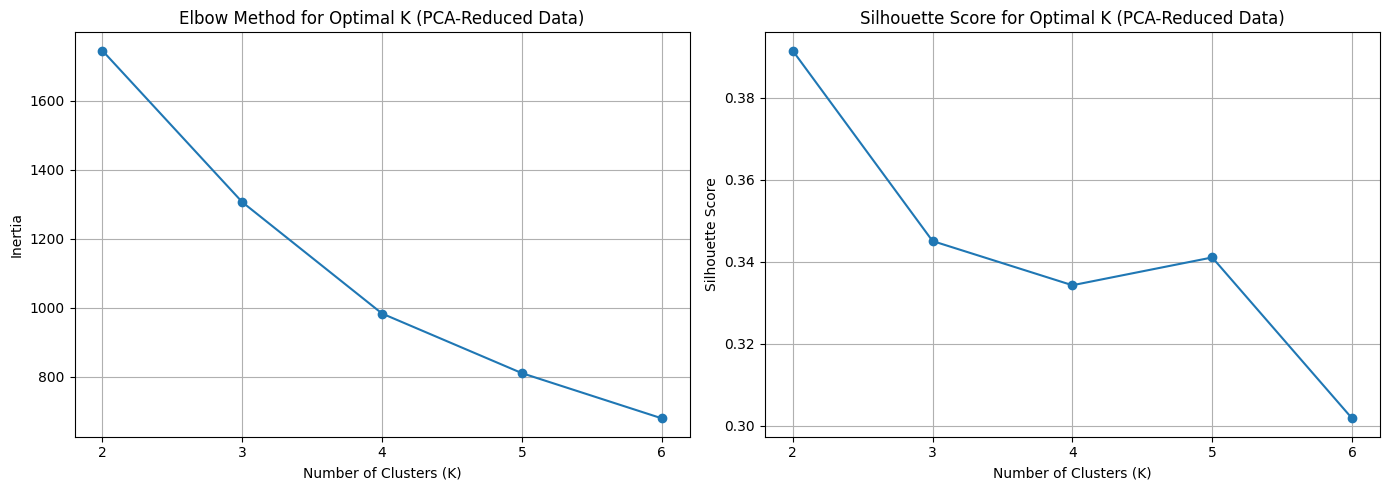

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the Inertia values against the number of clusters (K) to visualize the Elbow Method
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range[1:], inertia_pca[1:], marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (PCA-Reduced Data)')
plt.xticks(k_range[1:])
plt.grid(True)

# Plot the Silhouette Scores against the number of clusters (K)
plt.subplot(1, 2, 2)
# Adjusting k_range for silhouette plot as it starts from k=2
# The silhouette_scores_pca list has NaN at index 0 (for K=1), so we should plot from index 1
plt.plot(k_range[1:], silhouette_scores_pca[1:], marker='o') # k_range[1:] is [2, 3, 4, 5, 6], silhouette_scores_pca[1:] corresponds to scores for K=2, 3, 4, 5, 6
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K (PCA-Reduced Data)')
plt.xticks(k_range[1:])
plt.grid(True)

plt.tight_layout()
plt.show()

## Apply KMeans Clustering (K=2 and K=3)

### Subtask:
Apply KMeans clustering to the `features_for_clustering_pca` DataFrame for K=2 and K=3, and add the resulting cluster labels to the `pca_result_df` DataFrame.

**Reasoning**:
Instantiate and fit KMeans models for K=2 and K=3 using the `features_for_clustering_pca` DataFrame, and add the resulting cluster labels as new columns to the `pca_result_df` DataFrame.

In [ ]:
from sklearn.cluster import KMeans

# Apply KMeans clustering for K=2
kmeans_k2_pca = KMeans(n_clusters=2, random_state=42, n_init=10)
pca_result_df['cluster_k2_pca'] = kmeans_k2_pca.fit_predict(features_for_clustering_pca)

# Apply KMeans clustering for K=3
kmeans_k3_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
pca_result_df['cluster_k3_pca'] = kmeans_k3_pca.fit_predict(features_for_clustering_pca)

# Display the first few rows of the pca_result_df with the new cluster labels
print("PCA Results DataFrame with Cluster Labels (K=2 and K=3):")
display(pca_result_df.head())

# Display the count of feeders in each cluster for K=2 and K=3
print("\nFeeder Count per Cluster (K=2, PCA):")
print(pca_result_df['cluster_k2_pca'].value_counts().sort_index())

print("\nFeeder Count per Cluster (K=3, PCA):")
print(pca_result_df['cluster_k3_pca'].value_counts().sort_index())

PCA Results DataFrame with Cluster Labels (K=2 and K=3):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,cluster_k2_pca,cluster_k3_pca
0,-1.413646,-0.876046,0.916995,-0.200569,0.342328,-0.067138,-0.232278,0.074252,-0.039515,0.027723,-0.002137,-0.000098,0,0
1,2.891530,-0.113339,1.191758,-0.411101,0.511308,-0.335234,-0.266550,-0.070558,-0.184761,0.008235,-0.002740,0.000315,1,1
2,-1.912449,-0.694876,0.922570,-0.124788,0.386268,-0.119345,0.000314,0.040034,-0.013216,0.001292,-0.010707,0.000012,0,0
3,2.452982,-0.900628,0.524049,0.074944,0.661387,-0.094282,-0.256051,-0.122909,-0.011315,0.005842,0.010877,-0.000120,1,1
4,-2.267532,-0.785065,1.449287,-0.460933,0.220247,0.033882,0.003681,0.071023,-0.010178,0.001327,-0.016198,-0.000269,0,0



Feeder Count per Cluster (K=2, PCA):
cluster_k2_pca
0    181
1     63
Name: count, dtype: int64

Feeder Count per Cluster (K=3, PCA):
cluster_k3_pca
0    142
1     99
2      3
Name: count, dtype: int64


## Visualize Clustering Results (K=2)

### Subtask:
Generate 2D and 3D scatter plots for the clustering results with K=2, color-coded by cluster label.

**Reasoning**:
Generate 2D and 3D scatter plots for K=2 using the PCA components (PC1, PC2, PC3) and color-code the points by the cluster label.


Visualizing K=2 Clustering Results (PCA-Reduced Data):


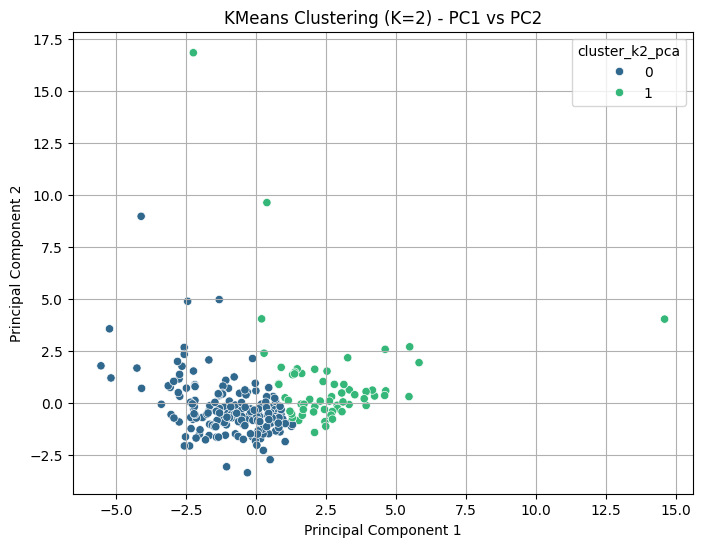

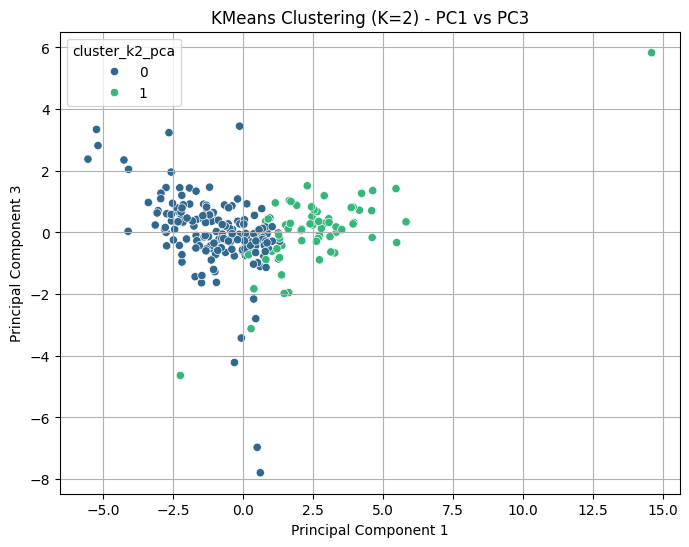

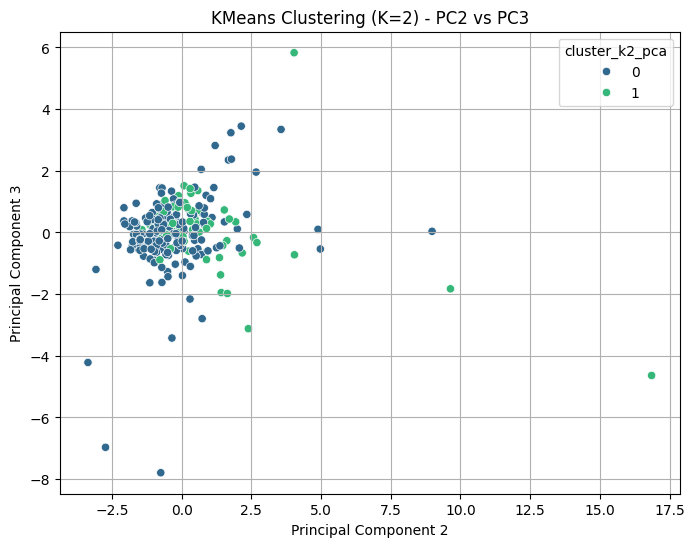

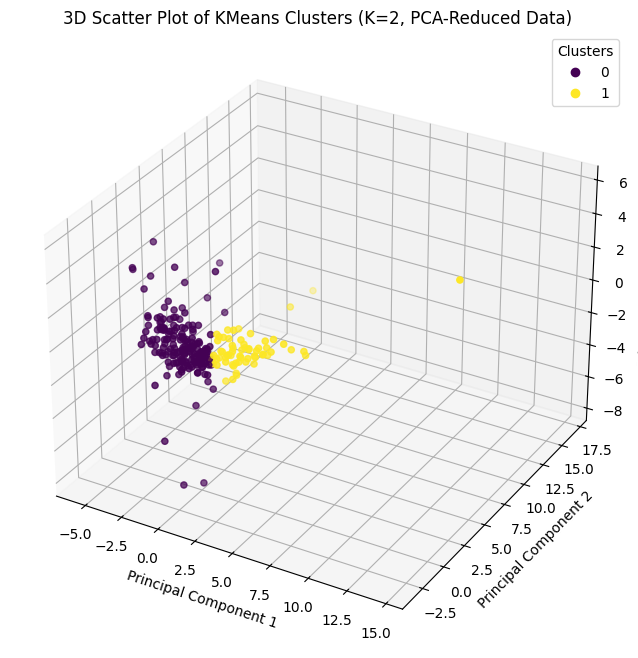

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Get the cluster centroids for K=2 to potentially add to plots
centroids_k2_pca = kmeans_k2_pca.cluster_centers_

print("\nVisualizing K=2 Clustering Results (PCA-Reduced Data):")

# 2D Scatter Plot: PC1 vs PC2
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster_k2_pca', data=pca_result_df, palette='viridis', legend='full')
plt.title('KMeans Clustering (K=2) - PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# Optional: Add centroids
# plt.scatter(centroids_k2_pca[:, 0], centroids_k2_pca[:, 1], marker='X', s=100, c='red', label='Centroids')
plt.grid(True)
plt.show()

# 2D Scatter Plot: PC1 vs PC3
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC3', hue='cluster_k2_pca', data=pca_result_df, palette='viridis', legend='full')
plt.title('KMeans Clustering (K=2) - PC1 vs PC3')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
# Optional: Add centroids
# plt.scatter(centroids_k2_pca[:, 0], centroids_k2_pca[:, 2], marker='X', s=100, c='red', label='Centroids')
plt.grid(True)
plt.show()

# 2D Scatter Plot: PC2 vs PC3
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC2', y='PC3', hue='cluster_k2_pca', data=pca_result_df, palette='viridis', legend='full')
plt.title('KMeans Clustering (K=2) - PC2 vs PC3')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
# Optional: Add centroids
# plt.scatter(centroids_k2_pca[:, 1], centroids_k2_pca[:, 2], marker='X', s=100, c='red', label='Centroids')
plt.grid(True)
plt.show()


# 3D Scatter Plot: PC1, PC2, PC3
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_result_df['PC1'],
                     pca_result_df['PC2'],
                     pca_result_df['PC3'],
                     c=pca_result_df['cluster_k2_pca'],
                     cmap='viridis',
                     marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Scatter Plot of KMeans Clusters (K=2, PCA-Reduced Data)')

# Add a legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

## Visualize Clustering Results (K=3)

### Subtask:
Generate 2D and 3D scatter plots for the clustering results with K=3, color-coded by cluster label.

**Reasoning**:
Generate 2D and 3D scatter plots for K=3 using the PCA components (PC1, PC2, PC3) and color-code the points by the cluster label.


Visualizing K=3 Clustering Results (PCA-Reduced Data):


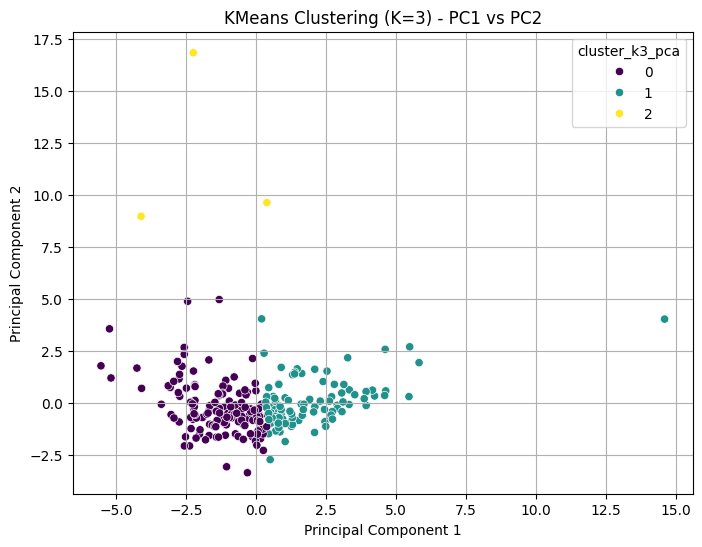

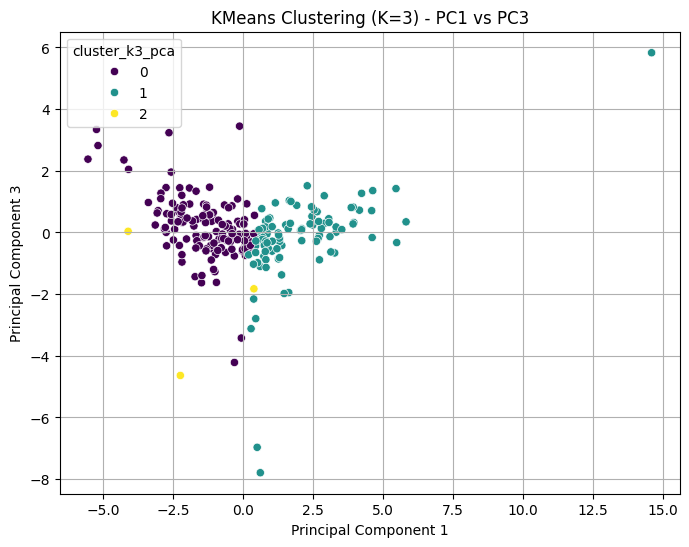

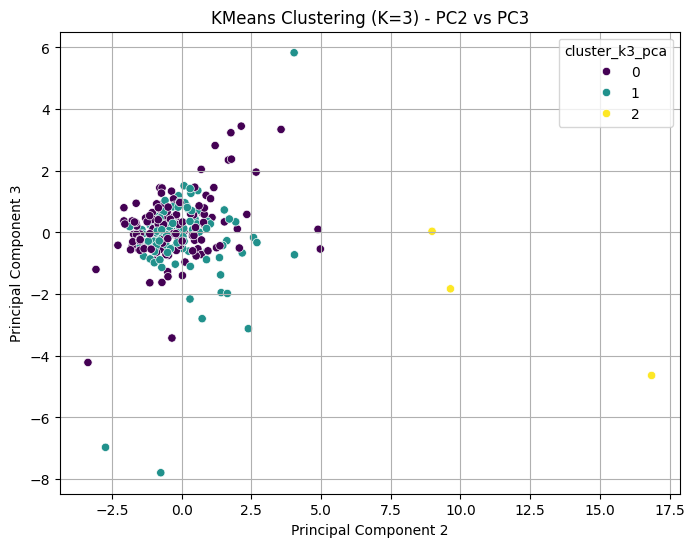

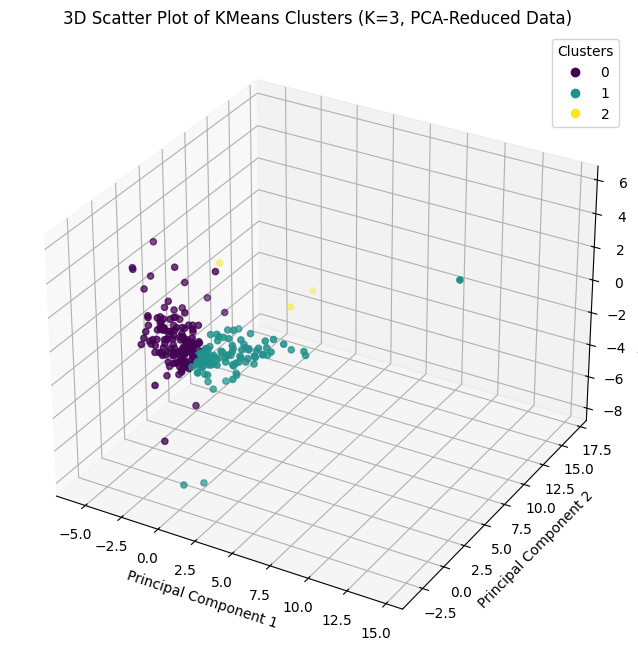

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Get the cluster centroids for K=3 to potentially add to plots
centroids_k3_pca = kmeans_k3_pca.cluster_centers_

print("\nVisualizing K=3 Clustering Results (PCA-Reduced Data):")

# 2D Scatter Plot: PC1 vs PC2
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster_k3_pca', data=pca_result_df, palette='viridis', legend='full')
plt.title('KMeans Clustering (K=3) - PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# Optional: Add centroids
# plt.scatter(centroids_k3_pca[:, 0], centroids_k3_pca[:, 1], marker='X', s=100, c='red', label='Centroids')
plt.grid(True)
plt.show()

# 2D Scatter Plot: PC1 vs PC3
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC3', hue='cluster_k3_pca', data=pca_result_df, palette='viridis', legend='full')
plt.title('KMeans Clustering (K=3) - PC1 vs PC3')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
# Optional: Add centroids
# plt.scatter(centroids_k3_pca[:, 0], centroids_k3_pca[:, 2], marker='X', s=100, c='red', label='Centroids')
plt.grid(True)
plt.show()

# 2D Scatter Plot: PC2 vs PC3
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC2', y='PC3', hue='cluster_k3_pca', data=pca_result_df, palette='viridis', legend='full')
plt.title('KMeans Clustering (K=3) - PC2 vs PC3')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
# Optional: Add centroids
# plt.scatter(centroids_k3_pca[:, 1], centroids_k3_pca[:, 2], marker='X', s=100, c='red', label='Centroids')
plt.grid(True)
plt.show()


# 3D Scatter Plot: PC1, PC2, PC3
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_result_df['PC1'],
                     pca_result_df['PC2'],
                     pca_result_df['PC3'],
                     c=pca_result_df['cluster_k3_pca'],
                     cmap='viridis',
                     marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Scatter Plot of KMeans Clusters (K=3, PCA-Reduced Data)')

# Add a legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

## Access Cluster Centroids

### Subtask:
Get the cluster centroids from the KMeans models fitted for K=2 and K=3 on the PCA-reduced data.

**Reasoning**:
Access the `cluster_centers_` attribute of the `kmeans_k2_pca` and `kmeans_k3_pca` objects to get the centroid coordinates in the PC space.

In [ ]:
# Access the cluster centroids for K=2
centroids_k2_pca = kmeans_k2_pca.cluster_centers_
print("Cluster Centroids for K=2 (PCA-Reduced Data):")
display(centroids_k2_pca)

# Access the cluster centroids for K=3
centroids_k3_pca = kmeans_k3_pca.cluster_centers_
print("\nCluster Centroids for K=3 (PCA-Reduced Data):")
display(centroids_k3_pca)

Cluster Centroids for K=2 (PCA-Reduced Data):


array([[-0.92077447, -0.3197268 , -0.0251837 ],
       [ 2.64539966,  0.91858017,  0.07235316]])


Cluster Centroids for K=3 (PCA-Reduced Data):


array([[-1.33667821, -0.2817588 ,  0.17605633],
       [ 1.97764913,  0.04574937, -0.18761223],
       [-1.99298587, 11.82685417, -2.14212913]])

## Format Centroids for Visualization

### Subtask:
Create a DataFrame for each K (2 and 3) with rows representing the clusters and columns representing the principal components (PC1, PC2, PC3), containing the centroid values.

**Reasoning**:
Convert the NumPy arrays of centroids for K=2 and K=3 into pandas DataFrames with appropriate column names (PC1, PC2, PC3) for easier handling and plotting.

In [ ]:
# Create a DataFrame for K=2 centroids
centroids_k2_pca_df = pd.DataFrame(centroids_k2_pca, columns=['PC1', 'PC2', 'PC3'])
centroids_k2_pca_df['cluster'] = centroids_k2_pca_df.index

print("\nK=2 Cluster Centroids DataFrame:")
display(centroids_k2_pca_df)

# Create a DataFrame for K=3 centroids
centroids_k3_pca_df = pd.DataFrame(centroids_k3_pca, columns=['PC1', 'PC2', 'PC3'])
centroids_k3_pca_df['cluster'] = centroids_k3_pca_df.index

print("\nK=3 Cluster Centroids DataFrame:")
display(centroids_k3_pca_df)


K=2 Cluster Centroids DataFrame:


,PC1,PC2,PC3,cluster
0,-0.920774,-0.319727,-0.025184,0
1,2.645400,0.918580,0.072353,1



K=3 Cluster Centroids DataFrame:


,PC1,PC2,PC3,cluster
0,-1.336678,-0.281759,0.176056,0
1,1.977649,0.045749,-0.187612,1
2,-1.992986,11.826854,-2.142129,2


## Visualize Centroids (Bar Charts)

### Subtask:
For K=2 and K=3 separately, create bar charts to visualize the centroid values for each cluster across the principal components (PC1, PC2, PC3).

**Reasoning**:
Melt the centroid DataFrames to a long format for easier plotting, then create bar charts for each K (2 and 3) showing the centroid values of PC1, PC2, and PC3 for each cluster.

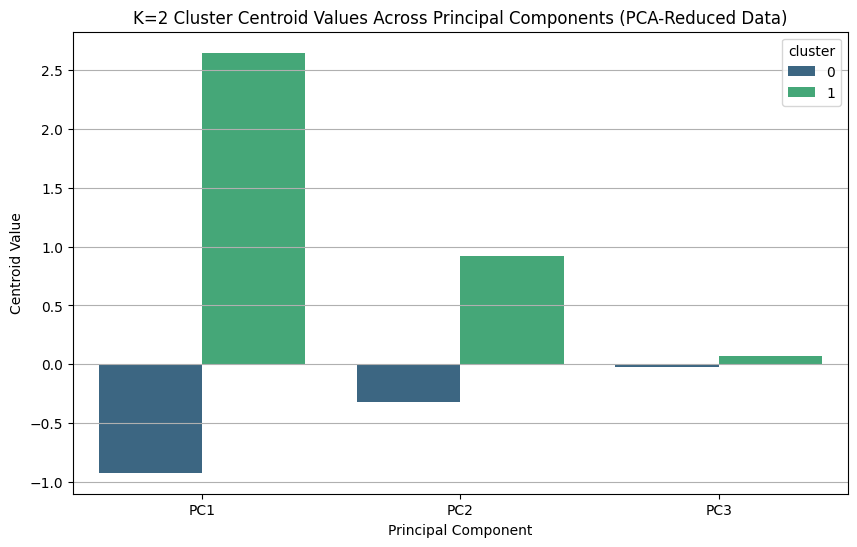

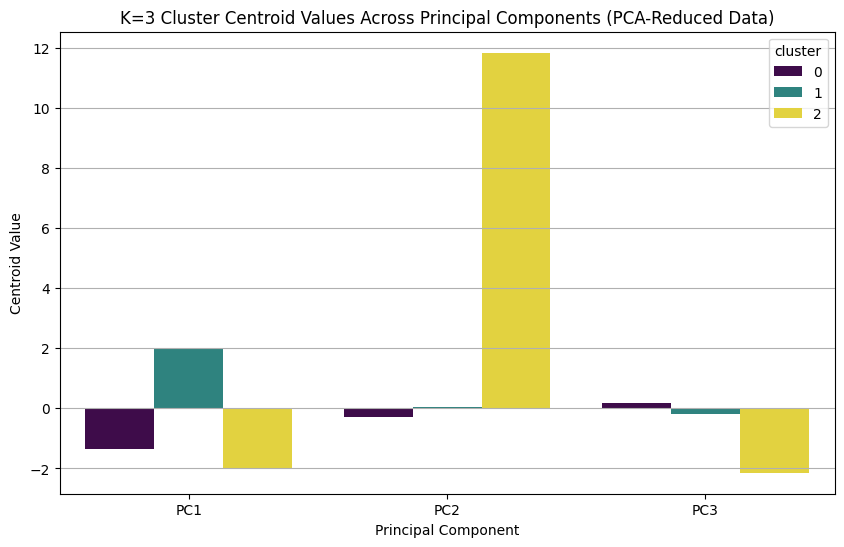

In [ ]:
# Melt the K=2 centroids DataFrame to long format for easier plotting
centroids_k2_pca_melted = centroids_k2_pca_df.melt(id_vars='cluster',
                                                 value_vars=['PC1', 'PC2', 'PC3'],
                                                 var_name='Principal Component',
                                                 value_name='Centroid Value')

# Create a bar chart for K=2 centroids
plt.figure(figsize=(10, 6))
sns.barplot(data=centroids_k2_pca_melted, x='Principal Component', y='Centroid Value', hue='cluster', palette='viridis')
plt.title('K=2 Cluster Centroid Values Across Principal Components (PCA-Reduced Data)')
plt.xlabel('Principal Component')
plt.ylabel('Centroid Value')
plt.grid(axis='y')
plt.show()

# Melt the K=3 centroids DataFrame to long format for easier plotting
centroids_k3_pca_melted = centroids_k3_pca_df.melt(id_vars='cluster',
                                                 value_vars=['PC1', 'PC2', 'PC3'],
                                                 var_name='Principal Component',
                                                 value_name='Centroid Value')

# Create a bar chart for K=3 centroids
plt.figure(figsize=(10, 6))
sns.barplot(data=centroids_k3_pca_melted, x='Principal Component', y='Centroid Value', hue='cluster', palette='viridis')
plt.title('K=3 Cluster Centroid Values Across Principal Components (PCA-Reduced Data)')
plt.xlabel('Principal Component')
plt.ylabel('Centroid Value')
plt.grid(axis='y')
plt.show()

## Summary of Cluster Centroids (PCA-Reduced Data)

Based on the cluster centroid bar charts for K=2 and K=3:

**For K=2:**

*   **Cluster 0:** This cluster generally represents feeders with lower overall consumption scale (PC1), lower per-device consumption intensity and variability (PC2), and potentially different consumption pattern shapes/temporal distributions (PC3, although the value is close to zero).
*   **Cluster 1:** This cluster generally represents feeders with higher overall consumption scale (PC1), higher per-device consumption intensity and variability (PC2), and potentially different consumption pattern shapes/temporal distributions (PC3, although the value is close to zero).

In essence, for K=2, the clustering primarily separates feeders into two broad groups based on their overall consumption magnitude and per-device characteristics.

**For K=3:**

*   **Cluster 0:** Similar to Cluster 0 in K=2, this cluster has negative centroid values for PC1 and PC3, and a negative value for PC2 (though closer to zero than Cluster 0 in K=2). This suggests lower consumption scale and different pattern shapes/temporal distributions.
*   **Cluster 1:** This cluster has a positive centroid value for PC1, and values close to zero for PC2 and PC3. This suggests a higher overall consumption scale, but with less distinct per-device characteristics or pattern shapes compared to Cluster 2.
*   **Cluster 2:** This cluster stands out with a very high positive centroid value for PC2 and a negative centroid value for PC3. This indicates that Cluster 2 represents feeders with very high per-device consumption intensity and variability (PC2), and a distinct consumption pattern shape/temporal distribution (PC3). The negative value for PC1 suggests a lower overall consumption scale compared to Cluster 1, which might seem counter-intuitive but could indicate a specific type of consumption behavior captured by the interaction of features in PC2 and PC3 that is not directly tied to the overall scale.

For K=3, the clustering appears to further differentiate feeders, particularly highlighting a group (Cluster 2) with unique per-device and pattern characteristics that are distinct from the general low and high consumption groups.

These centroid visualizations in the PC space provide a concise way to understand the defining characteristics of each cluster in terms of the underlying patterns captured by the principal components.

## Split Data and Apply PCA Transformation Seasonally

### Subtask:
Split the full dataset into seasonal subsets and apply the pre-fitted PCA transformation to each seasonal subset to project them into the PC1-PC3 space.

**Reasoning**:
Define the date ranges for each season, filter the original data by these ranges, and then apply the pre-fitted `scaler_pca` and `pca` objects to transform the seasonal data into the PCA space (PC1-PC3).

In [ ]:
# Define the date ranges for each season (using the same dates as before)
seasonal_dates = {
    'Winter': [('2024-02-12', '2024-02-29'), ('2024-12-01', '2025-02-28')],
    'Spring': [('2024-03-01', '2024-05-31'), ('2025-03-01', '2025-05-31')],
    'Summer': [('2024-06-01', '2024-08-31'), ('2025-06-01', '2025-08-31')],
    'Autumn': [('2024-09-01', '2024-11-30')]
}

# Convert string dates to datetime.date objects
seasonal_dates_dt = {}
for season, date_ranges in seasonal_dates.items():
    seasonal_dates_dt[season] = [(pd.to_datetime(start).date(), pd.to_datetime(end).date()) for start, end in date_ranges]


# Create a dictionary to store seasonal DataFrames in PCA space
seasonal_pca_features = {}

# Iterate through each season and its date ranges
for season, date_ranges in seasonal_dates_dt.items():
    print(f"\nProcessing {season}...")
    # Filter the original daily feeder features data for the current season's date ranges
    seasonal_data = pd.DataFrame()
    for start_date, end_date in date_ranges:
        range_data = daily_feeder_features[(daily_feeder_features['date'] >= start_date) & (daily_feeder_features['date'] <= end_date)]
        seasonal_data = pd.concat([seasonal_data, range_data])

    # Group by feeder ID and calculate the mean of the full feature columns for the season
    # Ensure only numeric columns are included in the aggregation
    seasonal_feeder_features_full = seasonal_data.groupby('lv_feeder_unique_id')[full_feature_columns_pca].mean().reset_index()


    # Apply the pre-fitted scaler to normalize the seasonal features
    # Ensure the order of columns is the same as during the original fitting
    seasonal_normalized_features = scaler_pca.transform(seasonal_feeder_features_full[full_feature_columns_pca])

    # Apply the pre-fitted PCA transformation to project into PC space (PC1-PC3)
    # We only need the first 3 components for clustering
    seasonal_pca_result = pca.transform(seasonal_normalized_features)[:, :3]


    # Create a DataFrame for the seasonal PCA results
    seasonal_pca_df = pd.DataFrame(seasonal_pca_result, columns=['PC1', 'PC2', 'PC3'])

    # Add the feeder ID back to the seasonal PCA DataFrame
    seasonal_pca_df['lv_feeder_unique_id'] = seasonal_feeder_features_full['lv_feeder_unique_id']

    # Store the seasonal PCA DataFrame in the dictionary
    seasonal_pca_features[season] = seasonal_pca_df

    print(f"{season} data processed and transformed into PC space.")
    display(seasonal_pca_features[season].head())


Processing Winter...
Winter data processed and transformed into PC space.


,PC1,PC2,PC3,lv_feeder_unique_id
0,-1.536867,0.298112,1.329435,SSEN-400600301501
1,3.983153,0.502654,1.460120,SSEN-400600301502
2,-1.588589,-0.414164,0.791470,SSEN-400600301503
3,3.342624,-0.149110,0.953252,SSEN-400600301504
4,-2.073124,-0.462770,1.438597,SSEN-400600301505



Processing Spring...
Spring data processed and transformed into PC space.


,PC1,PC2,PC3,lv_feeder_unique_id
0,-1.331982,-0.816991,0.789735,SSEN-400600301501
1,2.612418,-0.341163,1.132338,SSEN-400600301502
2,-1.893447,-0.770683,1.003191,SSEN-400600301503
3,2.364968,-1.015933,0.490898,SSEN-400600301504
4,-2.255138,-0.849213,1.436841,SSEN-400600301505



Processing Summer...
Summer data processed and transformed into PC space.


,PC1,PC2,PC3,lv_feeder_unique_id
0,-1.553275,-1.936889,0.464419,SSEN-400600301501
1,1.689743,-0.665308,0.878190,SSEN-400600301502
2,-2.582435,-0.822333,1.122226,SSEN-400600301503
3,1.270724,-1.708370,-0.013434,SSEN-400600301504
4,-2.675713,-1.088361,1.482497,SSEN-400600301505



Processing Autumn...
Autumn data processed and transformed into PC space.


,PC1,PC2,PC3,lv_feeder_unique_id
0,-1.276042,-1.215266,1.190134,SSEN-400600301501
1,3.500882,0.232677,1.343098,SSEN-400600301502
2,-1.588054,-0.733711,0.691003,SSEN-400600301503
3,2.892110,-0.660245,0.679953,SSEN-400600301504
4,-2.068094,-0.700306,1.450290,SSEN-400600301505


# Task
Explain the error in the provided Python code for seasonal clustering and alignment, fix the error, and incorporate the corrected code. The code should perform seasonal clustering (KMeans with K=2 and K=3) on PCA-transformed seasonal data, align the clusters of Spring, Summer, and Autumn to Winter using centroid similarity and the Hungarian algorithm, store the aligned cluster labels, visualize the aligned seasonal clustering with 3D scatter plots, visualize the seasonal centroids with bar charts, and save the final cluster assignments.

## Seasonal clustering (k=2 and k=3)

### Subtask:
For each season, apply KMeans clustering with K=2 and K=3 to the PCA-transformed seasonal data.


**Reasoning**:
I will iterate through the `seasonal_pca_features` dictionary. For each season, I will apply KMeans clustering for both K=2 and K=3, and add the resulting cluster labels to the respective seasonal DataFrame. Finally, I will display the head of the 'Winter' DataFrame to verify the changes.



In [ ]:
# Create a dictionary to store the seasonal KMeans models for later access if needed
seasonal_kmeans_models = {'k2': {}, 'k3': {}}

# Iterate through each season's PCA-transformed data
for season, pca_df in seasonal_pca_features.items():
    # Features for clustering are PC1, PC2, and PC3
    features = pca_df[['PC1', 'PC2', 'PC3']]

    # Apply KMeans for K=2
    kmeans_k2 = KMeans(n_clusters=2, random_state=42, n_init=10)
    pca_df['cluster_k2'] = kmeans_k2.fit_predict(features)
    seasonal_kmeans_models['k2'][season] = kmeans_k2

    # Apply KMeans for K=3
    kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init=10)
    pca_df['cluster_k3'] = kmeans_k3.fit_predict(features)
    seasonal_kmeans_models['k3'][season] = kmeans_k3

# Display the first few rows of the 'Winter' DataFrame to verify the new cluster columns
print("Winter PCA Features with Cluster Labels (K=2 and K=3):")
display(seasonal_pca_features['Winter'].head())

Winter PCA Features with Cluster Labels (K=2 and K=3):


,PC1,PC2,PC3,lv_feeder_unique_id,cluster_k2,cluster_k3
0,-1.536867,0.298112,1.329435,SSEN-400600301501,1,2
1,3.983153,0.502654,1.460120,SSEN-400600301502,0,0
2,-1.588589,-0.414164,0.791470,SSEN-400600301503,1,2
3,3.342624,-0.149110,0.953252,SSEN-400600301504,0,0
4,-2.073124,-0.462770,1.438597,SSEN-400600301505,1,2


**Reasoning**:
I need to align the clusters of Spring, Summer, and Autumn to the Winter clusters for both K=2 and K=3. This involves calculating centroid similarity between seasons and using the Hungarian algorithm to find the optimal mapping.



In [ ]:
from scipy.optimize import linear_sum_assignment # Ensure linear_sum_assignment is imported

def align_clusters(centroids_from, centroids_to):
    """
    Aligns clusters from one set of centroids to another using the Hungarian algorithm.

    Args:
        centroids_from (np.ndarray): Centroids of the clusters to be aligned.
        centroids_to (np.ndarray): Centroids of the reference clusters.

    Returns:
        dict: A mapping from original cluster labels in centroids_from to
              aligned cluster labels based on centroids_to.
    """
    # Calculate the distance matrix between the centroids
    # dist_matrix[i, j] is the distance between centroid i from 'from' and centroid j from 'to'
    dist_matrix = np.linalg.norm(centroids_from[:, np.newaxis] - centroids_to, axis=2)

    # Apply the Hungarian algorithm to find the optimal assignment
    # row_ind are the indices of the 'from' clusters, col_ind are the indices of the 'to' clusters
    row_ind, col_ind = linear_sum_assignment(dist_matrix)

    # Create a mapping from the original cluster labels to the aligned cluster labels
    alignment_mapping = {original_label: aligned_label for original_label, aligned_label in zip(row_ind, col_ind)}

    return alignment_mapping

# Store aligned cluster labels for each season and K
seasonal_aligned_cluster_labels = {'k2': {}, 'k3': {}}

# Align clusters for K=2
print("\nAligning K=2 Clusters Seasonally:")
winter_centroids_k2 = seasonal_kmeans_models['k2']['Winter'].cluster_centers_
for season in ['Spring', 'Summer', 'Autumn']:
    season_pca_df = seasonal_pca_features[season]
    features = season_pca_df[['PC1', 'PC2', 'PC3']]

    # Apply KMeans for K=2, initializing with Winter centroids
    # Use n_init=1 as we are providing explicit initial centroids
    kmeans_k2 = KMeans(n_clusters=2, random_state=42, init=winter_centroids_k2, n_init=1)
    season_pca_df['cluster_k2'] = kmeans_k2.fit_predict(features)
    seasonal_kmeans_models['k2'][season] = kmeans_k2 # Store the updated model

    season_centroids_k2 = seasonal_kmeans_models['k2'][season].cluster_centers_
    alignment_mapping_k2 = align_clusters(season_centroids_k2, winter_centroids_k2)
    seasonal_aligned_cluster_labels['k2'][season] = alignment_mapping_k2
    # Apply the alignment mapping to the seasonal DataFrame
    season_pca_df[f'{season}_aligned_cluster_k2'] = season_pca_df['cluster_k2'].map(alignment_mapping_k2)
    print(f"{season} K=2 clusters aligned to Winter.")

# Align clusters for K=3
print("\nAligning K=3 Clusters Seasonally:")
winter_centroids_k3 = seasonal_kmeans_models['k3']['Winter'].cluster_centers_
for season in ['Spring', 'Summer', 'Autumn']:
    season_pca_df = seasonal_pca_features[season]
    features = season_pca_df[['PC1', 'PC2', 'PC3']]

    # Apply KMeans for K=3, initializing with Winter centroids
    # Use n_init=1 as we are providing explicit initial centroids
    kmeans_k3 = KMeans(n_clusters=3, random_state=42, init=winter_centroids_k3, n_init=1)
    season_pca_df['cluster_k3'] = kmeans_k3.fit_predict(features)
    seasonal_kmeans_models['k3'][season] = kmeans_k3 # Store the updated model

    season_centroids_k3 = seasonal_kmeans_models['k3'][season].cluster_centers_
    alignment_mapping_k3 = align_clusters(season_centroids_k3, winter_centroids_k3)
    seasonal_aligned_cluster_labels['k3'][season] = alignment_mapping_k3
    # Apply the alignment mapping to the seasonal DataFrame
    season_pca_df[f'{season}_aligned_cluster_k3'] = season_pca_df['cluster_k3'].map(alignment_mapping_k3)
    print(f"{season} K=3 clusters aligned to Winter.")

# Also add the original Winter cluster labels as 'aligned' for consistency
seasonal_pca_features['Winter']['Winter_aligned_cluster_k2'] = seasonal_pca_features['Winter']['cluster_k2']
seasonal_aligned_cluster_labels['k2']['Winter'] = {i: i for i in range(seasonal_kmeans_models['k2']['Winter'].n_clusters)}

seasonal_pca_features['Winter']['Winter_aligned_cluster_k3'] = seasonal_pca_features['Winter']['cluster_k3']
seasonal_aligned_cluster_labels['k3']['Winter'] = {i: i for i in range(seasonal_kmeans_models['k3']['Winter'].n_clusters)}


# Display the first few rows of the updated DataFrames to verify aligned cluster labels
print("\nSpring PCA Features with Aligned Cluster Labels (K=2 and K=3):")
display(seasonal_pca_features['Spring'].head())

print("\nSummer PCA Features with Aligned Cluster Labels (K=2 and K=3):")
display(seasonal_pca_features['Summer'].head())

print("\nAutumn PCA Features with Aligned Cluster Labels (K=2 and K=3):")
display(seasonal_pca_features['Autumn'].head())

print("\nWinter PCA Features with Aligned Cluster Labels (K=2 and K=3):")
display(seasonal_pca_features['Winter'].head())


Aligning K=2 Clusters Seasonally:
Spring K=2 clusters aligned to Winter.
Summer K=2 clusters aligned to Winter.
Autumn K=2 clusters aligned to Winter.

Aligning K=3 Clusters Seasonally:
Spring K=3 clusters aligned to Winter.
Summer K=3 clusters aligned to Winter.
Autumn K=3 clusters aligned to Winter.

Spring PCA Features with Aligned Cluster Labels (K=2 and K=3):


,PC1,PC2,PC3,lv_feeder_unique_id,cluster_k2,cluster_k3,Spring_aligned_cluster_k2,Spring_aligned_cluster_k3
0,-1.331982,-0.816991,0.789735,SSEN-400600301501,1,2,1,2
1,2.612418,-0.341163,1.132338,SSEN-400600301502,0,0,0,0
2,-1.893447,-0.770683,1.003191,SSEN-400600301503,1,2,1,2
3,2.364968,-1.015933,0.490898,SSEN-400600301504,0,0,0,0
4,-2.255138,-0.849213,1.436841,SSEN-400600301505,1,2,1,2



Summer PCA Features with Aligned Cluster Labels (K=2 and K=3):


,PC1,PC2,PC3,lv_feeder_unique_id,cluster_k2,cluster_k3,Summer_aligned_cluster_k2,Summer_aligned_cluster_k3
0,-1.553275,-1.936889,0.464419,SSEN-400600301501,1,2,1,2
1,1.689743,-0.665308,0.878190,SSEN-400600301502,0,0,0,0
2,-2.582435,-0.822333,1.122226,SSEN-400600301503,1,2,1,2
3,1.270724,-1.708370,-0.013434,SSEN-400600301504,0,0,0,0
4,-2.675713,-1.088361,1.482497,SSEN-400600301505,1,2,1,2



Autumn PCA Features with Aligned Cluster Labels (K=2 and K=3):


,PC1,PC2,PC3,lv_feeder_unique_id,cluster_k2,cluster_k3,Autumn_aligned_cluster_k2,Autumn_aligned_cluster_k3
0,-1.276042,-1.215266,1.190134,SSEN-400600301501,1,2,1,2
1,3.500882,0.232677,1.343098,SSEN-400600301502,0,0,0,0
2,-1.588054,-0.733711,0.691003,SSEN-400600301503,1,2,1,2
3,2.892110,-0.660245,0.679953,SSEN-400600301504,0,0,0,0
4,-2.068094,-0.700306,1.450290,SSEN-400600301505,1,2,1,2



Winter PCA Features with Aligned Cluster Labels (K=2 and K=3):


,PC1,PC2,PC3,lv_feeder_unique_id,cluster_k2,cluster_k3,Winter_aligned_cluster_k2,Winter_aligned_cluster_k3
0,-1.536867,0.298112,1.329435,SSEN-400600301501,1,2,1,2
1,3.983153,0.502654,1.460120,SSEN-400600301502,0,0,0,0
2,-1.588589,-0.414164,0.791470,SSEN-400600301503,1,2,1,2
3,3.342624,-0.149110,0.953252,SSEN-400600301504,0,0,0,0
4,-2.073124,-0.462770,1.438597,SSEN-400600301505,1,2,1,2


**Reasoning**:
Now that the seasonal clusters are aligned, I need to merge the aligned cluster labels for K=2 and K=3 from the seasonal PCA DataFrames back into a single DataFrame keyed by feeder ID, creating new columns for each season's aligned cluster label.



In [ ]:
# Initialize a list to hold the DataFrames for merging
aligned_cluster_dfs = []

# Iterate through each season and its seasonal PCA DataFrame
for season, pca_df in seasonal_pca_features.items():
    # Select the feeder ID and the aligned cluster columns for K=2 and K=3
    # Rename the aligned cluster columns to include the season name for clarity during merging
    aligned_cols_k2 = f'{season}_aligned_cluster_k2'
    aligned_cols_k3 = f'{season}_aligned_cluster_k3'

    temp_df = pca_df[['lv_feeder_unique_id', aligned_cols_k2, aligned_cols_k3]].copy()

    # Append the temporary DataFrame to the list
    aligned_cluster_dfs.append(temp_df)

# Merge the DataFrames in the list based on the 'lv_feeder_unique_id' column
# The first DataFrame in the list serves as the base
merged_aligned_clusters_pca = aligned_cluster_dfs[0]
for i in range(1, len(aligned_cluster_dfs)):
    merged_aligned_clusters_pca = pd.merge(merged_aligned_clusters_pca, aligned_cluster_dfs[i], on='lv_feeder_unique_id', how='outer')

# Display the first few rows of the merged DataFrame
print("\nMerged Aligned Seasonal Cluster Labels (PCA-Reduced Data):")
display(merged_aligned_clusters_pca.head())

# Display information about the merged DataFrame
print("\nInformation about the Merged Aligned Seasonal Cluster Labels DataFrame:")
merged_aligned_clusters_pca.info()


Merged Aligned Seasonal Cluster Labels (PCA-Reduced Data):


,lv_feeder_unique_id,Winter_aligned_cluster_k2,Winter_aligned_cluster_k3,Spring_aligned_cluster_k2,Spring_aligned_cluster_k3,Summer_aligned_cluster_k2,Summer_aligned_cluster_k3,Autumn_aligned_cluster_k2,Autumn_aligned_cluster_k3
0,SSEN-400600301501,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0
1,SSEN-400600301502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SSEN-400600301503,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0
3,SSEN-400600301504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SSEN-400600301505,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0



Information about the Merged Aligned Seasonal Cluster Labels DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lv_feeder_unique_id        244 non-null    object 
 1   Winter_aligned_cluster_k2  240 non-null    float64
 2   Winter_aligned_cluster_k3  240 non-null    float64
 3   Spring_aligned_cluster_k2  241 non-null    float64
 4   Spring_aligned_cluster_k3  241 non-null    float64
 5   Summer_aligned_cluster_k2  242 non-null    float64
 6   Summer_aligned_cluster_k3  242 non-null    float64
 7   Autumn_aligned_cluster_k2  238 non-null    float64
 8   Autumn_aligned_cluster_k3  238 non-null    float64
dtypes: float64(8), object(1)
memory usage: 17.3+ KB


**Reasoning**:
To quantify the temporal stability of each feeder's cluster membership across the seasons, I need to count how many times a feeder changes cluster assignment from one season to the next, considering the transitions across the full year (Winter to Spring, Spring to Summer, Summer to Autumn, and Autumn to Winter). I will then calculate a stability score based on the number of changes.



In [ ]:
# Define the list of aligned seasonal cluster columns for K=3
season_cols_k3 = [f'{season}_aligned_cluster_k3' for season in seasonal_dates.keys()]

# Calculate the number of cluster changes for each feeder across consecutive seasons (cyclic) for K=3
# Fill NaN values with a placeholder to treat missing values as a distinct state for change calculation
merged_aligned_clusters_pca_filled_k3 = merged_aligned_clusters_pca[season_cols_k3].fillna(-1)

# Calculate the number of changes for each feeder across the full cycle
def count_cyclic_changes(row, season_cols):
    changes = 0
    for i in range(len(season_cols)):
        # Compare current season to the next season in the cycle (including Autumn to Winter)
        current_season_col = season_cols[i]
        next_season_col = season_cols[(i + 1) % len(season_cols)] # Use modulo for cyclic transition

        if row[current_season_col] != row[next_season_col]:
            changes += 1
    return changes

# Apply the function to calculate cluster changes for K=3
merged_aligned_clusters_pca['cluster_changes_cyclic_k3'] = merged_aligned_clusters_pca_filled_k3.apply(
    lambda row: count_cyclic_changes(row, season_cols_k3), axis=1
)

# Calculate a simple stability score: inverse of changes (higher score = more stable)
# Adding 1 to the denominator to avoid division by zero if a feeder has 0 changes.
merged_aligned_clusters_pca['stability_score_cyclic_k3'] = 1 / (merged_aligned_clusters_pca['cluster_changes_cyclic_k3'] + 1)

# Display the first few rows with the new stability score for K=3
print("\nFeeder Cyclic Stability Scores (K=3, PCA-Reduced Data):")
display(merged_aligned_clusters_pca[['lv_feeder_unique_id', 'cluster_changes_cyclic_k3', 'stability_score_cyclic_k3']].head())

# Display the distribution of stability scores for K=3
print("\nDistribution of Feeder Cyclic Stability Scores (K=3, PCA-Reduced Data):")
print(merged_aligned_clusters_pca['stability_score_cyclic_k3'].value_counts().sort_index())

# Display the distribution of cluster changes for K=3
print("\nDistribution of Feeder Cyclic Cluster Changes (K=3, PCA-Reduced Data):")
print(merged_aligned_clusters_pca['cluster_changes_cyclic_k3'].value_counts().sort_index())


# Repeat for K=2
# Define the list of aligned seasonal cluster columns for K=2
season_cols_k2 = [f'{season}_aligned_cluster_k2' for season in seasonal_dates.keys()]

# Calculate the number of cluster changes for each feeder across consecutive seasons (cyclic) for K=2
# Fill NaN values with a placeholder
merged_aligned_clusters_pca_filled_k2 = merged_aligned_clusters_pca[season_cols_k2].fillna(-1)

# Apply the function to calculate cluster changes for K=2
merged_aligned_clusters_pca['cluster_changes_cyclic_k2'] = merged_aligned_clusters_pca_filled_k2.apply(
    lambda row: count_cyclic_changes(row, season_cols_k2), axis=1
)

# Calculate a simple stability score for K=2
merged_aligned_clusters_pca['stability_score_cyclic_k2'] = 1 / (merged_aligned_clusters_pca['cluster_changes_cyclic_k2'] + 1)

# Display the first few rows with the new stability score for K=2
print("\nFeeder Cyclic Stability Scores (K=2, PCA-Reduced Data):")
display(merged_aligned_clusters_pca[['lv_feeder_unique_id', 'cluster_changes_cyclic_k2', 'stability_score_cyclic_k2']].head())

# Display the distribution of stability scores for K=2
print("\nDistribution of Feeder Cyclic Stability Scores (K=2, PCA-Reduced Data):")
print(merged_aligned_clusters_pca['stability_score_cyclic_k2'].value_counts().sort_index())

# Display the distribution of cluster changes for K=2
print("\nDistribution of Feeder Cyclic Cluster Changes (K=2, PCA-Reduced Data):")
print(merged_aligned_clusters_pca['cluster_changes_cyclic_k2'].value_counts().sort_index())


Feeder Cyclic Stability Scores (K=3, PCA-Reduced Data):


,lv_feeder_unique_id,cluster_changes_cyclic_k3,stability_score_cyclic_k3
0,SSEN-400600301501,0,1.0
1,SSEN-400600301502,0,1.0
2,SSEN-400600301503,0,1.0
3,SSEN-400600301504,0,1.0
4,SSEN-400600301505,0,1.0



Distribution of Feeder Cyclic Stability Scores (K=3, PCA-Reduced Data):
stability_score_cyclic_k3
0.250000      1
0.333333     56
1.000000    187
Name: count, dtype: int64

Distribution of Feeder Cyclic Cluster Changes (K=3, PCA-Reduced Data):
cluster_changes_cyclic_k3
0    187
2     56
3      1
Name: count, dtype: int64

Feeder Cyclic Stability Scores (K=2, PCA-Reduced Data):


,lv_feeder_unique_id,cluster_changes_cyclic_k2,stability_score_cyclic_k2
0,SSEN-400600301501,0,1.0
1,SSEN-400600301502,0,1.0
2,SSEN-400600301503,0,1.0
3,SSEN-400600301504,0,1.0
4,SSEN-400600301505,0,1.0



Distribution of Feeder Cyclic Stability Scores (K=2, PCA-Reduced Data):
stability_score_cyclic_k2
0.200000      1
0.333333     53
1.000000    190
Name: count, dtype: int64

Distribution of Feeder Cyclic Cluster Changes (K=2, PCA-Reduced Data):
cluster_changes_cyclic_k2
0    190
2     53
4      1
Name: count, dtype: int64


## Seasonal clustering (k=2 and k=3)

### Subtask:
For each season, apply KMeans clustering with K=2 and K=3 to the PCA-transformed seasonal data.

**Reasoning**:
I will iterate through the `seasonal_pca_features` dictionary. For each season, I will apply KMeans clustering for both K=2 and K=3, and add the resulting cluster labels to the respective seasonal DataFrame. Finally, I will display the head of the 'Winter' DataFrame to verify the changes.

In [ ]:
# # Create a dictionary to store the seasonal KMeans models for later access if needed
# seasonal_kmeans_models = {'k2': {}, 'k3': {}}

# # Iterate through each season's PCA-transformed data
# for season, pca_df in seasonal_pca_features.items():
#     # Features for clustering are PC1, PC2, and PC3
#     features = pca_df[['PC1', 'PC2', 'PC3']]

#     # Apply KMeans for K=2
#     kmeans_k2 = KMeans(n_clusters=2, random_state=42, n_init=10)
#     pca_df['cluster_k2'] = kmeans_k2.fit_predict(features)
#     seasonal_kmeans_models['k2'][season] = kmeans_k2

#     # Apply KMeans for K=3
#     kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init=10)
#     pca_df['cluster_k3'] = kmeans_k3.fit_predict(features)
#     seasonal_kmeans_models['k3'][season] = kmeans_k3

# # Display the first few rows of the 'Winter' DataFrame to verify the new cluster columns
# print("Winter PCA Features with Cluster Labels (K=2 and K=3):")
# display(seasonal_pca_features['Winter'].head())

## Store Aligned Cluster Labels

### Subtask:
Merge the aligned cluster labels for K=2 and K=3 from the seasonal PCA DataFrames into a single DataFrame keyed by feeder ID.

**Reasoning**:
Now that the seasonal clusters are aligned, I need to merge the aligned cluster labels for K=2 and K=3 from the seasonal PCA DataFrames back into a single DataFrame keyed by feeder ID, creating new columns for each season's aligned cluster label.

In [ ]:
# Initialize a list to hold the DataFrames for merging
aligned_cluster_dfs = []

# Iterate through each season and its seasonal PCA DataFrame
for season, pca_df in seasonal_pca_features.items():
    # Select the feeder ID and the aligned cluster columns for K=2 and K=3
    # Rename the aligned cluster columns to include the season name for clarity during merging
    aligned_cols_k2 = f'{season}_aligned_cluster_k2'
    aligned_cols_k3 = f'{season}_aligned_cluster_k3'

    temp_df = pca_df[['lv_feeder_unique_id', aligned_cols_k2, aligned_cols_k3]].copy()

    # Append the temporary DataFrame to the list
    aligned_cluster_dfs.append(temp_df)

# Merge the DataFrames in the list based on the 'lv_feeder_unique_id' column
# The first DataFrame in the list serves as the base
merged_aligned_clusters_pca = aligned_cluster_dfs[0]
for i in range(1, len(aligned_cluster_dfs)):
    merged_aligned_clusters_pca = pd.merge(merged_aligned_clusters_pca, aligned_cluster_dfs[i], on='lv_feeder_unique_id', how='outer')

# Display the first few rows of the merged DataFrame
print("\nMerged Aligned Seasonal Cluster Labels (PCA-Reduced Data):")
display(merged_aligned_clusters_pca.head())

# Display information about the merged DataFrame
print("\nInformation about the Merged Aligned Seasonal Cluster Labels DataFrame:")
merged_aligned_clusters_pca.info()


Merged Aligned Seasonal Cluster Labels (PCA-Reduced Data):


,lv_feeder_unique_id,Winter_aligned_cluster_k2,Winter_aligned_cluster_k3,Spring_aligned_cluster_k2,Spring_aligned_cluster_k3,Summer_aligned_cluster_k2,Summer_aligned_cluster_k3,Autumn_aligned_cluster_k2,Autumn_aligned_cluster_k3
0,SSEN-400600301501,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0
1,SSEN-400600301502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SSEN-400600301503,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0
3,SSEN-400600301504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SSEN-400600301505,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0



Information about the Merged Aligned Seasonal Cluster Labels DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lv_feeder_unique_id        244 non-null    object 
 1   Winter_aligned_cluster_k2  240 non-null    float64
 2   Winter_aligned_cluster_k3  240 non-null    float64
 3   Spring_aligned_cluster_k2  241 non-null    float64
 4   Spring_aligned_cluster_k3  241 non-null    float64
 5   Summer_aligned_cluster_k2  242 non-null    float64
 6   Summer_aligned_cluster_k3  242 non-null    float64
 7   Autumn_aligned_cluster_k2  238 non-null    float64
 8   Autumn_aligned_cluster_k3  238 non-null    float64
dtypes: float64(8), object(1)
memory usage: 17.3+ KB


## Visualize Aligned Seasonal Clustering (K=2 and K=3)

### Subtask:
Generate 3D scatter plots for each season and K (2 and 3), color-coded by the aligned cluster label.

**Reasoning**:
Iterate through each season, access its PCA-transformed data with aligned cluster labels, and generate a 3D scatter plot using PC1, PC2, and PC3, color-coding the points by the aligned cluster label for both K=2 and K=3.

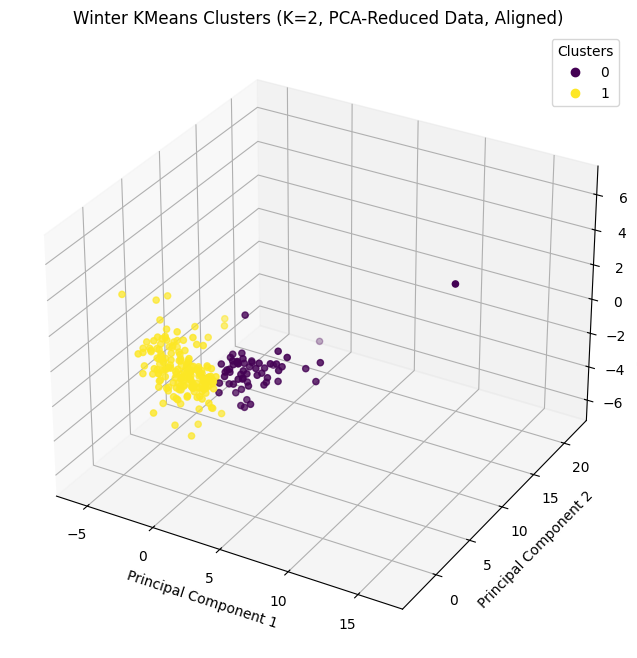

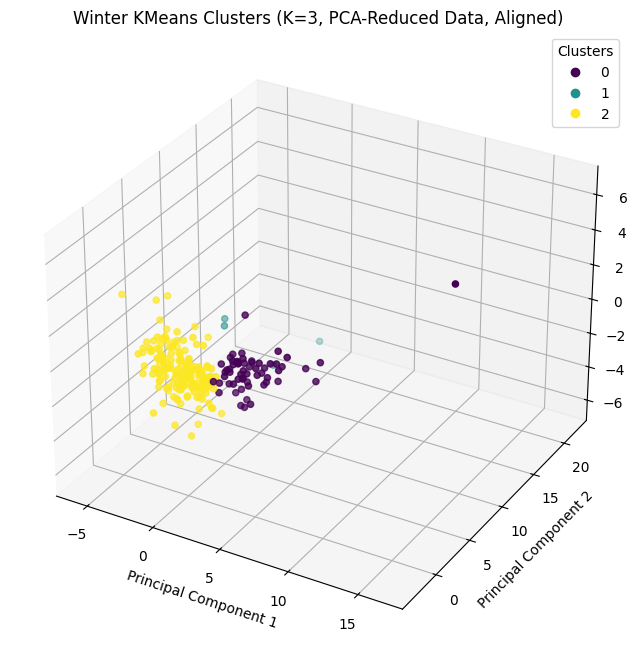

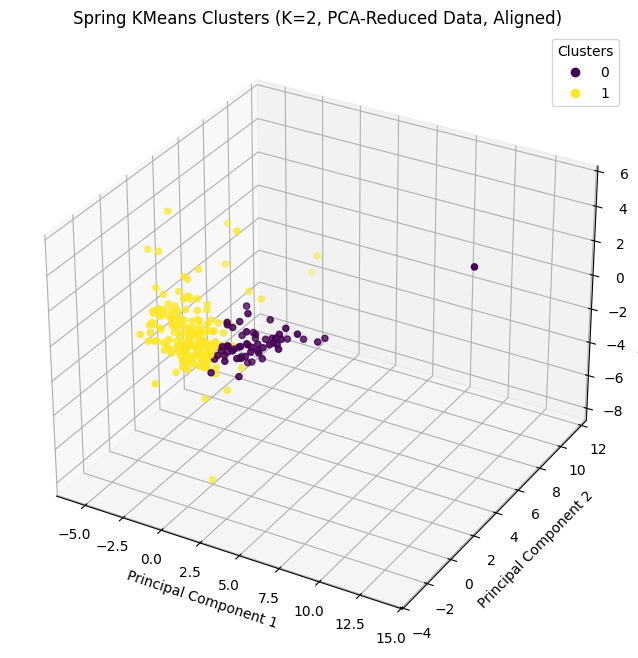

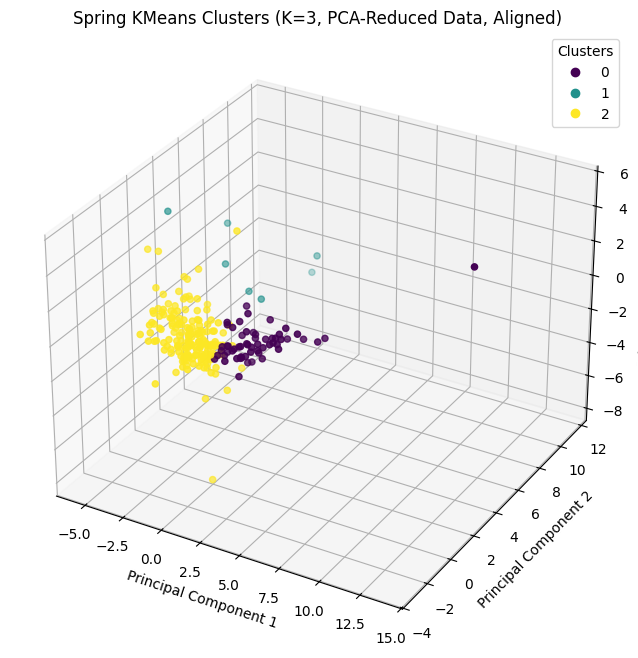

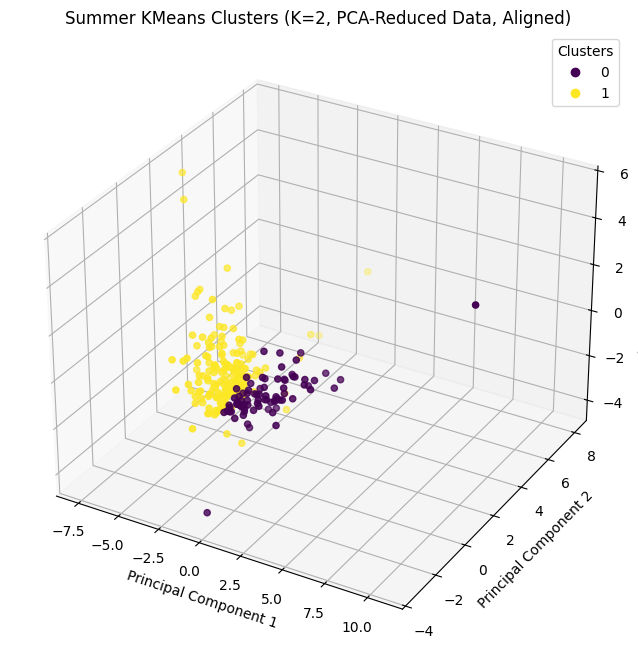

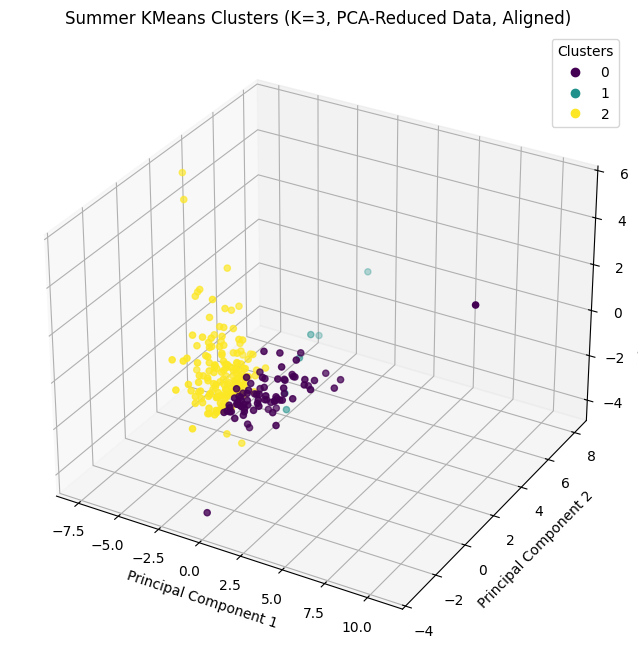

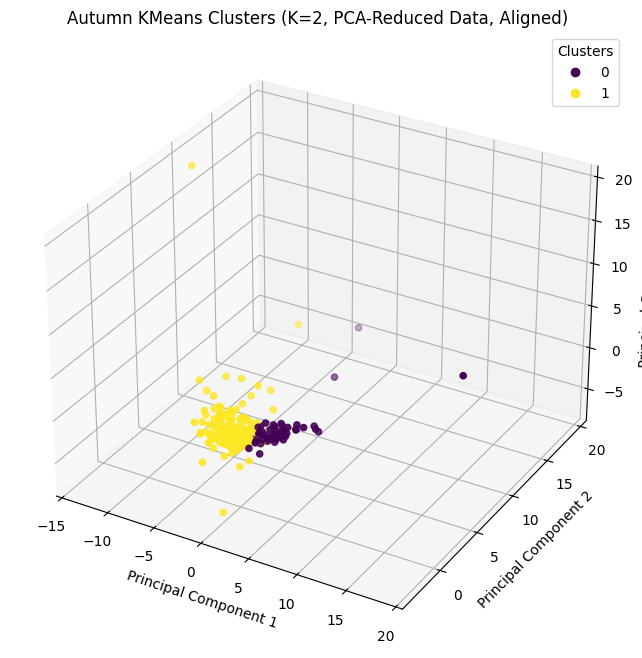

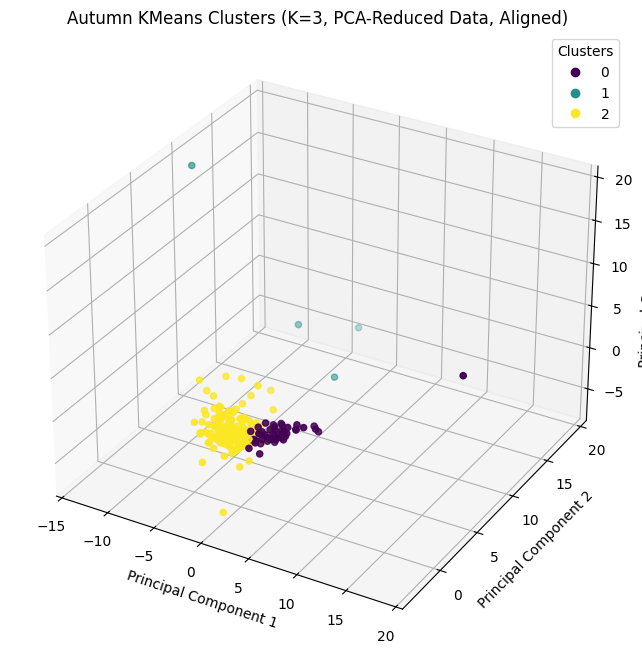

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate through each season
for season, pca_df in seasonal_pca_features.items():
    # Visualize for K=2
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(pca_df['PC1'],
                         pca_df['PC2'],
                         pca_df['PC3'],
                         c=pca_df[f'{season}_aligned_cluster_k2'],
                         cmap='viridis',
                         marker='o')

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(f'{season} KMeans Clusters (K=2, PCA-Reduced Data, Aligned)')

    # Add a legend
    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

    # Visualize for K=3
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(pca_df['PC1'],
                         pca_df['PC2'],
                         pca_df['PC3'],
                         c=pca_df[f'{season}_aligned_cluster_k3'],
                         cmap='viridis',
                         marker='o')

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(f'{season} KMeans Clusters (K=3, PCA-Reduced Data, Aligned)')

    # Add a legend
    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

## Prepare Centroid Data for Visualization

### Subtask:
Combine the aligned seasonal cluster centroids into a single DataFrame and format it for visualization.

**Reasoning**:
Retrieve the aligned cluster centroids for each season and K from the `seasonal_kmeans_models` dictionary, convert them into DataFrames, add a 'season' column, and then concatenate them into a single DataFrame. Finally, melt the DataFrame to a long format suitable for bar plotting.

In [ ]:
# Create empty dictionaries to store seasonal centroids
seasonal_centroids_k2 = {}
seasonal_centroids_k3 = {}

# Iterate through each season and retrieve the centroids from the fitted KMeans models
for season in seasonal_pca_features.keys():
    seasonal_centroids_k2[season] = seasonal_kmeans_models['k2'][season].cluster_centers_
    seasonal_centroids_k3[season] = seasonal_kmeans_models['k3'][season].cluster_centers_


# Convert the dictionaries of centroids into DataFrames and add a 'season' column
centroid_dfs_k2 = []
for season, centroids in seasonal_centroids_k2.items():
    df = pd.DataFrame(centroids, columns=['PC1', 'PC2', 'PC3'])
    df['season'] = season
    df['cluster'] = df.index # Add cluster label as a column
    centroid_dfs_k2.append(df)

centroid_dfs_k3 = []
for season, centroids in seasonal_centroids_k3.items():
    df = pd.DataFrame(centroids, columns=['PC1', 'PC2', 'PC3'])
    df['season'] = season
    df['cluster'] = df.index # Add cluster label as a column
    centroid_dfs_k3.append(df)


# Concatenate the seasonal centroid DataFrames
all_seasonal_centroids_k2 = pd.concat(centroid_dfs_k2)
all_seasonal_centroids_k3 = pd.concat(centroid_dfs_k3)

# Melt the DataFrames to long format for easier plotting
all_seasonal_centroids_k2_melted = all_seasonal_centroids_k2.melt(
    id_vars=['season', 'cluster'],
    value_vars=['PC1', 'PC2', 'PC3'],
    var_name='Principal Component',
    value_name='Centroid Value'
)

all_seasonal_centroids_k3_melted = all_seasonal_centroids_k3.melt(
    id_vars=['season', 'cluster'],
    value_vars=['PC1', 'PC2', 'PC3'],
    var_name='Principal Component',
    value_name='Centroid Value'
)


# Display the first few rows of the melted DataFrames
print("\nMelted Seasonal Cluster Centroids (K=2, PCA-Reduced Data):")
display(all_seasonal_centroids_k2_melted.head())

print("\nMelted Seasonal Cluster Centroids (K=3, PCA-Reduced Data):")
display(all_seasonal_centroids_k3_melted.head())


Melted Seasonal Cluster Centroids (K=2, PCA-Reduced Data):


,season,cluster,Principal Component,Centroid Value
0,Winter,0,PC1,3.957626
1,Winter,1,PC1,-0.399404
2,Spring,0,PC1,2.803120
3,Spring,1,PC1,-0.926248
4,Summer,0,PC1,1.104345



Melted Seasonal Cluster Centroids (K=3, PCA-Reduced Data):


,season,cluster,Principal Component,Centroid Value
0,Winter,0,PC1,4.075357
1,Winter,1,PC1,-1.354364
2,Winter,2,PC1,-0.392451
3,Spring,0,PC1,2.830985
4,Spring,1,PC1,-2.441338


## Visualize Seasonal Centroids (Bar Charts)

### Subtask:
Create bar charts to visualize the centroid values for each aligned cluster across the principal components (PC1, PC2, PC3) for each season and K (2 and 3).

**Reasoning**:
Create bar charts for K=2 and K=3 separately, showing the centroid values of PC1, PC2, and PC3 for each cluster, grouped by season.

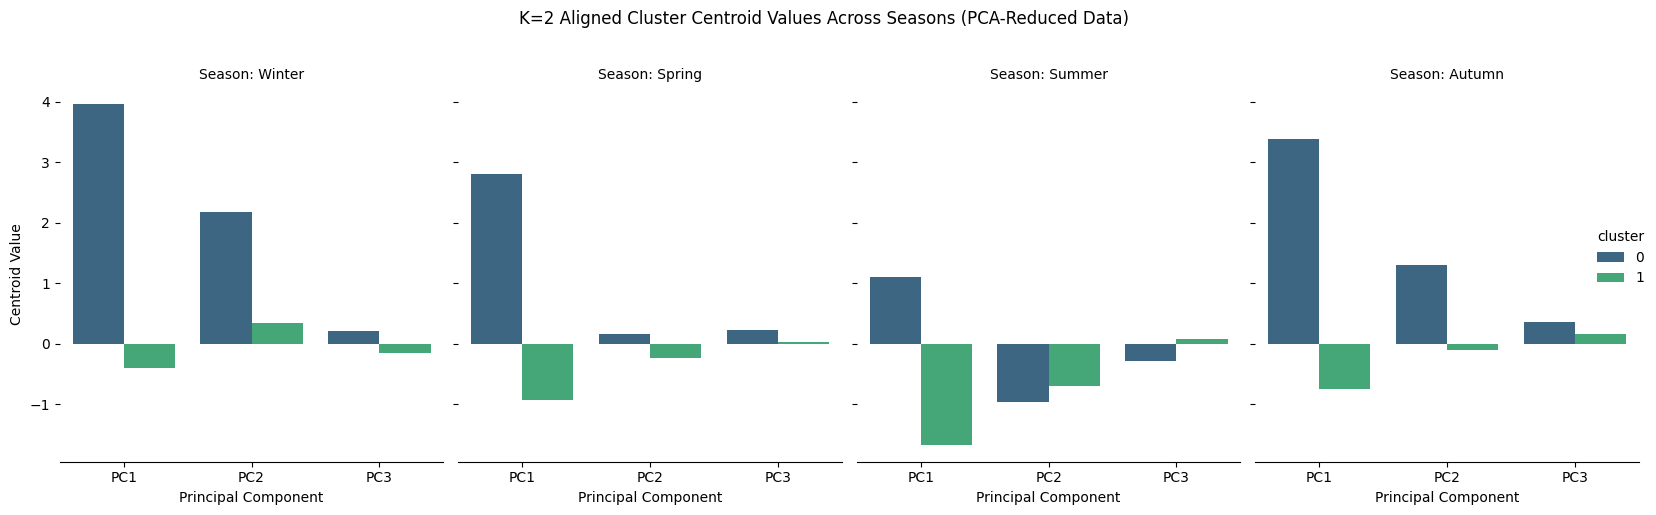

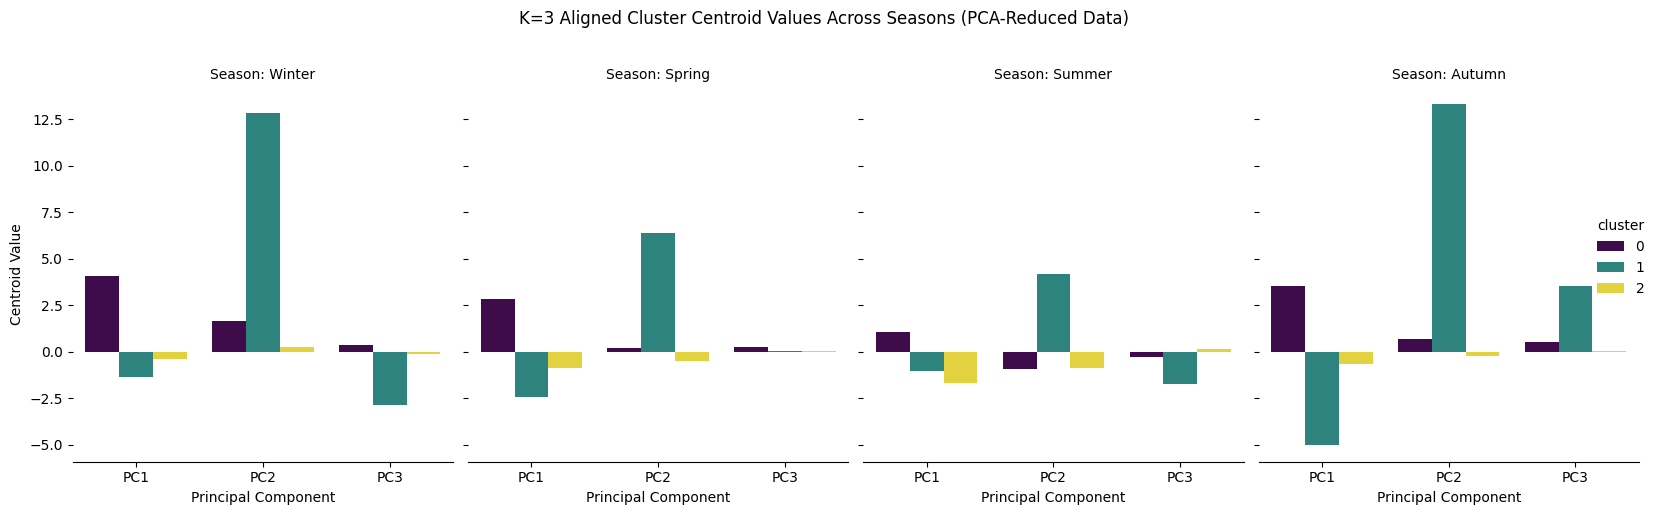

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize K=2 centroids using bar charts for each season
g = sns.catplot(data=all_seasonal_centroids_k2_melted, x='Principal Component', y='Centroid Value',
                hue='cluster', col='season', kind='bar', palette='viridis', height=5, aspect=.8)
g.fig.suptitle('K=2 Aligned Cluster Centroid Values Across Seasons (PCA-Reduced Data)', y=1.02)
g.set_titles("Season: {col_name}")
g.set_axis_labels("Principal Component", "Centroid Value")
g.despine(left=True)
plt.tight_layout()
plt.show()

# Visualize K=3 centroids using bar charts for each season
g = sns.catplot(data=all_seasonal_centroids_k3_melted, x='Principal Component', y='Centroid Value',
                hue='cluster', col='season', kind='bar', palette='viridis', height=5, aspect=.8)
g.fig.suptitle('K=3 Aligned Cluster Centroid Values Across Seasons (PCA-Reduced Data)', y=1.02)
g.set_titles("Season: {col_name}")
g.set_axis_labels("Principal Component", "Centroid Value")
g.despine(left=True)
plt.tight_layout()
plt.show()

## Save Final Cluster Assignments

### Subtask:
Save the seasonal DataFrames with the aligned cluster labels for K=2 and K=3.

**Reasoning**:
Iterate through the `seasonal_pca_features` dictionary and save each seasonal DataFrame with the aligned cluster labels to a CSV file.

In [ ]:
# import os

# # Define the directory to save the cluster assignments
# save_dir = '/content/drive/MyDrive/SSEN LV Aggregated Substations/Seasonal_PCA_Cluster_Assignments'
# os.makedirs(save_dir, exist_ok=True)

# # Iterate through each season and its seasonal PCA DataFrame
# for season, pca_df in seasonal_pca_features.items():
#     # Define the filename for the current season
#     filename = f'{season}_pca_aligned_cluster_assignments.csv'
#     filepath = os.path.join(save_dir, filename)

#     # Save the DataFrame to a CSV file
#     pca_df.to_csv(filepath, index=False)

#     print(f"Saved aligned cluster assignments for {season} to {filepath}")

## Visualize Aligned Seasonal Centroids (Alternate Bar Charts)

### Subtask:
Create bar charts for each aligned cluster (for K=2 and K=3 separately), showing the centroid values for PC1, PC2, and PC3, with each season represented as a separate bar within each principal component group.

**Reasoning**:
To create the requested visualization, I need to filter the melted centroid DataFrames for each cluster, and then create bar plots for each cluster, using 'Principal Component' on the x-axis, 'Centroid Value' on the y-axis, and 'season' as the hue. I will do this for both K=2 and K=3.


Visualizing K=2 Aligned Cluster Centroid Values (by Cluster):


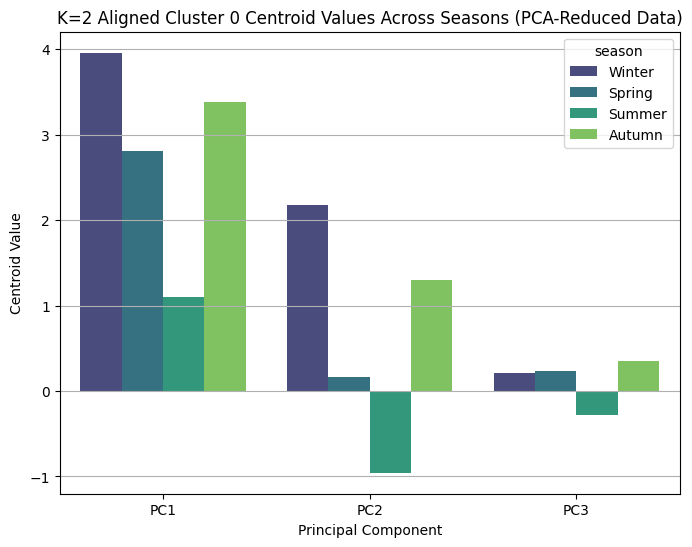

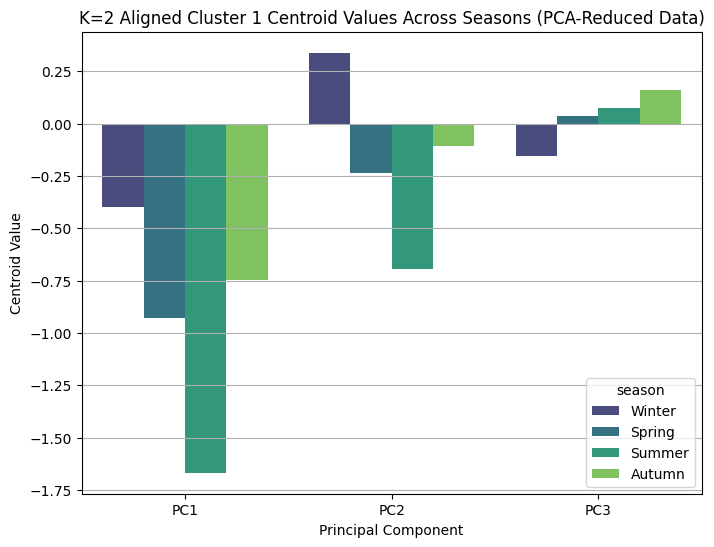


Visualizing K=3 Aligned Cluster Centroid Values (by Cluster):


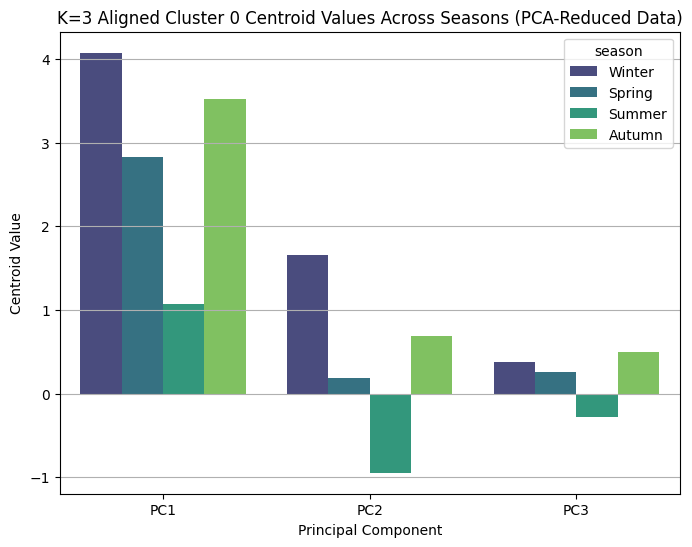

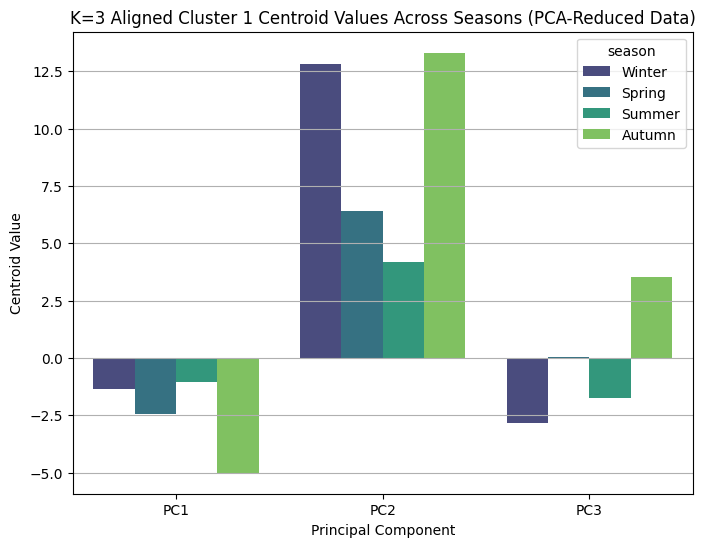

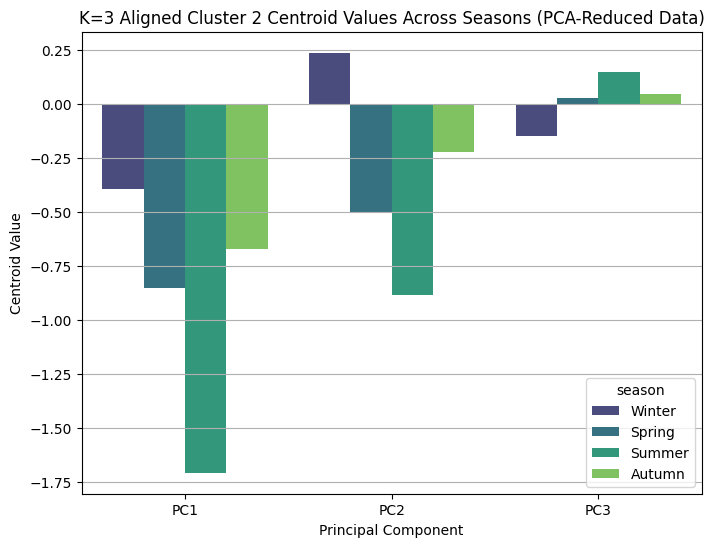

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize K=2 centroids by cluster
print("\nVisualizing K=2 Aligned Cluster Centroid Values (by Cluster):")
for cluster_label in all_seasonal_centroids_k2_melted['cluster'].unique():
    subset_data = all_seasonal_centroids_k2_melted[all_seasonal_centroids_k2_melted['cluster'] == cluster_label]

    plt.figure(figsize=(8, 6))
    sns.barplot(data=subset_data, x='Principal Component', y='Centroid Value', hue='season', palette='viridis')
    plt.title(f'K=2 Aligned Cluster {cluster_label} Centroid Values Across Seasons (PCA-Reduced Data)')
    plt.xlabel('Principal Component')
    plt.ylabel('Centroid Value')
    plt.grid(axis='y')
    plt.show()

# Visualize K=3 centroids by cluster
print("\nVisualizing K=3 Aligned Cluster Centroid Values (by Cluster):")
for cluster_label in all_seasonal_centroids_k3_melted['cluster'].unique():
    subset_data = all_seasonal_centroids_k3_melted[all_seasonal_centroids_k3_melted['cluster'] == cluster_label]

    plt.figure(figsize=(8, 6))
    sns.barplot(data=subset_data, x='Principal Component', y='Centroid Value', hue='season', palette='viridis')
    plt.title(f'K=3 Aligned Cluster {cluster_label} Centroid Values Across Seasons (PCA-Reduced Data)')
    plt.xlabel('Principal Component')
    plt.ylabel('Centroid Value')
    plt.grid(axis='y')
    plt.show()

## Save Final Cluster Assignments

### Subtask:
Save the seasonal DataFrames with the aligned cluster labels for K=2 and K=3.

**Reasoning**:
Iterate through the `seasonal_pca_features` dictionary and save each seasonal DataFrame with the aligned cluster labels to a CSV file.

In [ ]:
# import os

# # Define the directory to save the cluster assignments
# save_dir = '/content/drive/MyDrive/SSEN LV Aggregated Substations/Seasonal_PCA_Cluster_Assignments'
# os.makedirs(save_dir, exist_ok=True)

# # Iterate through each season and its seasonal PCA DataFrame
# for season, pca_df in seasonal_pca_features.items():
#     # Define the filename for the current season
#     filename = f'{season}_pca_aligned_cluster_assignments.csv'
#     filepath = os.path.join(save_dir, filename)

#     # Save the DataFrame to a CSV file
#     pca_df.to_csv(filepath, index=False)

#     print(f"Saved aligned cluster assignments for {season} to {filepath}")

# Task
Write a modular Python script (Google Colab compatible) to save pre-fitted PCA and KMeans models, and corresponding cluster assignments (full time series and seasonal for K=2 and K=3) to a specified Google Drive folder, ensuring the directory exists and confirming successful saves. Assume Google Drive is mounted at `/content/drive/`. Do not re-run PCA or KMeans.

## Define save paths

### Subtask:
Define the base directory path in Google Drive where the models and cluster assignments will be saved.


**Reasoning**:
Define the base directory path in Google Drive where the models and cluster assignments will be saved.



In [ ]:
# Define the base directory to save models and cluster assignments
save_dir = '/content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA'
print(f"Saving results and models to: {save_dir}")

Saving results and models to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA


## Create directory

### Subtask:
Ensure the save directory exists in Google Drive; create it if it doesn't.


**Reasoning**:
Ensure the save directory exists in Google Drive; create it if it doesn't.



In [ ]:
# Ensure the save directory exists, create it if it doesn't
import os
os.makedirs(save_dir, exist_ok=True)
print(f"Save directory ensured: {save_dir}")

Save directory ensured: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA


## Save pca model

### Subtask:
Save the fitted PCA model (`pca`) to a pickle file.


**Reasoning**:
Save the fitted PCA model to a pickle file within the defined save directory.



In [ ]:
import pickle

# Define the full path for saving the PCA model file
pca_model_path = os.path.join(save_dir, 'pca_model.pkl')

# Open the file path in write-binary mode and save the PCA model
with open(pca_model_path, 'wb') as f:
    pickle.dump(pca, f)

# Print a confirmation message
print(f"Fitted PCA model saved successfully to: {pca_model_path}")

Fitted PCA model saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/pca_model.pkl


**Reasoning**:
Save the fitted KMeans model for K=2 (PCA-reduced data) to a pickle file within the defined save directory.



In [ ]:
# Define the full path for saving the KMeans K=2 PCA model file
kmeans_k2_pca_model_path = os.path.join(save_dir, 'kmeans_k2_pca_model.pkl')

# Open the file path in write-binary mode and save the KMeans K=2 PCA model
with open(kmeans_k2_pca_model_path, 'wb') as f:
    pickle.dump(kmeans_k2_pca, f)

# Print a confirmation message
print(f"Fitted KMeans K=2 PCA model saved successfully to: {kmeans_k2_pca_model_path}")

Fitted KMeans K=2 PCA model saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k2_pca_model.pkl


**Reasoning**:
Save the fitted KMeans model for K=3 (PCA-reduced data) to a pickle file within the defined save directory.



In [ ]:
# Define the full path for saving the KMeans K=3 PCA model file
kmeans_k3_pca_model_path = os.path.join(save_dir, 'kmeans_k3_pca_model.pkl')

# Open the file path in write-binary mode and save the KMeans K=3 PCA model
with open(kmeans_k3_pca_model_path, 'wb') as f:
    pickle.dump(kmeans_k3_pca, f)

# Print a confirmation message
print(f"Fitted KMeans K=3 PCA model saved successfully to: {kmeans_k3_pca_model_path}")

Fitted KMeans K=3 PCA model saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k3_pca_model.pkl


**Reasoning**:
Save the full time series cluster assignments (K=2 and K=3) to a CSV file.



In [ ]:
# Define the full path for saving the full time series cluster assignments file
full_cluster_assignments_path = os.path.join(save_dir, 'full_time_series_cluster_assignments_pca.csv')

# Check if pca_result_df and feeder_level_features exist
if 'pca_result_df' in locals() and 'feeder_level_features' in locals():
    # Merge the cluster assignments with feeder IDs from feeder_level_features
    # Ensure the index alignment is correct, assuming pca_result_df rows correspond to feeder_level_features rows
    # It's safer to merge on an explicit ID if available or reset index to merge on index
    # Assuming the order is the same, we can directly assign or merge on index after resetting
    full_assignments_with_id = pca_result_df.copy()
    full_assignments_with_id['lv_feeder_unique_id'] = feeder_level_features['lv_feeder_unique_id']

    # Reorder columns to have feeder_id first for clarity
    cols = ['lv_feeder_unique_id'] + [col for col in full_assignments_with_id.columns if col != 'lv_feeder_unique_id']
    full_assignments_with_id = full_assignments_with_id[cols]

    # Save the DataFrame with feeder IDs to a CSV file
    full_assignments_with_id.to_csv(full_cluster_assignments_path, index=False)

    # Print a confirmation message
    print(f"Full time series cluster assignments (PCA-reduced) saved successfully to: {full_cluster_assignments_path}")
else:
    print("Error: Required DataFrames (pca_result_df or feeder_level_features) not found. Cannot save cluster assignments with feeder IDs.")

Full time series cluster assignments (PCA-reduced) saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/full_time_series_cluster_assignments_pca.csv


**Reasoning**:
Iterate through the seasonal PCA DataFrames and save each one with aligned cluster labels to a CSV file.



In [ ]:
# Iterate through each season and its seasonal PCA DataFrame
for season, pca_df in seasonal_pca_features.items():
    # Define the filename for the current season
    filename = f'{season}_pca_aligned_cluster_assignments.csv'
    filepath = os.path.join(save_dir, filename)

    # Save the DataFrame to a CSV file
    pca_df.to_csv(filepath, index=False)

    print(f"Saved aligned cluster assignments for {season} to {filepath}")

Saved aligned cluster assignments for Winter to /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/Winter_pca_aligned_cluster_assignments.csv
Saved aligned cluster assignments for Spring to /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/Spring_pca_aligned_cluster_assignments.csv
Saved aligned cluster assignments for Summer to /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/Summer_pca_aligned_cluster_assignments.csv
Saved aligned cluster assignments for Autumn to /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/Autumn_pca_aligned_cluster_assignments.csv


## Summary:

### Data Analysis Key Findings

*   The base directory for saving results and models was set to `/content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA`.
*   The specified save directory was successfully created or confirmed to exist in Google Drive.
*   The fitted PCA model was successfully saved to `/content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/pca_model.pkl`.
*   The fitted KMeans K=2 PCA model was successfully saved to `/content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k2_pca_model.pkl`.
*   The fitted KMeans K=3 PCA model was successfully saved to `/content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k3_pca_model.pkl`.
*   The full time series cluster assignments (PCA-reduced) were successfully saved to `/content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/full_time_series_cluster_assignments_pca.csv`.
*   Aligned cluster assignments for each season (Winter, Spring, Summer, Autumn) were successfully saved to individual CSV files within the specified directory.

### Insights or Next Steps

*   The successful saving of models and cluster assignments provides a persistent record of the clustering analysis for future use or sharing.
*   The modular script can be adapted to save other models or data artifacts by modifying the save paths and object names.


## Save Seasonal KMeans Models

### Subtask:
Iterate through the seasonal KMeans models (`seasonal_kmeans_models`) and save each fitted model to a pickle file.

**Reasoning**:
Iterate through the nested dictionary `seasonal_kmeans_models` (keyed by K and then by season), and save each fitted KMeans model to a pickle file with a descriptive filename including K and the season.

In [ ]:
import os
import pickle

# Iterate through the seasonal_kmeans_models dictionary
for k_value, seasonal_models in seasonal_kmeans_models.items():
    for season, model in seasonal_models.items():
        # Define the filename for the current seasonal KMeans model
        filename = f'kmeans_{k_value}_{season.lower()}.pkl'
        filepath = os.path.join(save_dir, filename)

        # Open the file path in write-binary mode and save the KMeans model
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)

        # Print a confirmation message
        print(f"Fitted KMeans {k_value} model for {season} saved successfully to: {filepath}")

Fitted KMeans k2 model for Winter saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k2_winter.pkl
Fitted KMeans k2 model for Spring saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k2_spring.pkl
Fitted KMeans k2 model for Summer saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k2_summer.pkl
Fitted KMeans k2 model for Autumn saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k2_autumn.pkl
Fitted KMeans k3 model for Winter saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k3_winter.pkl
Fitted KMeans k3 model for Spring saved successfully to: /content/drive/MyDrive/SSEN LV Aggregated Substations/Clustering_Results_and_Models_PCA/kmeans_k3_spring.pkl
Fitt

## Save Seasonal Cluster Assignments

### Subtask:
Check for the existence of the `merged_aligned_clusters_pca` DataFrame, and if it exists, save the feeder IDs and aligned seasonal cluster labels for K=2 and K=3 to CSV files.

**Reasoning**:
Check for the existence of the `merged_aligned_clusters_pca` DataFrame, and if it exists, save the feeder IDs and aligned seasonal cluster labels for K=2 and K=3 to CSV files.

In [ ]:
import os

# Define the directory to save the cluster assignments
# Assuming save_dir is already defined from previous steps
# save_dir = '/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/00. Models & Cluster Assignments'
# os.makedirs(save_dir, exist_ok=True) # Ensure directory exists

# Define the base filename for seasonal cluster assignments
seasonal_assignments_filename_base = 'seasonal_pca_aligned_cluster_assignments'

# Check if the merged_aligned_clusters_pca DataFrame exists
if 'merged_aligned_clusters_pca' in locals():

    # Save K=2 seasonal assignments
    filename_k2 = f'{seasonal_assignments_filename_base}_k2.csv'
    filepath_k2 = os.path.join(save_dir, filename_k2)
    # Select the feeder ID and K=2 aligned cluster columns
    cols_to_save_k2 = ['lv_feeder_unique_id'] + [col for col in merged_aligned_clusters_pca.columns if col.endswith('_aligned_cluster_k2')]
    merged_aligned_clusters_pca[cols_to_save_k2].to_csv(filepath_k2, index=False)
    print(f"Seasonal aligned cluster assignments (K=2, PCA-reduced) saved successfully to: {filepath_k2}")

    # Save K=3 seasonal assignments
    filename_k3 = f'{seasonal_assignments_filename_base}_k3.csv'
    filepath_k3 = os.path.join(save_dir, filename_k3)
    # Select the feeder ID and K=3 aligned cluster columns
    cols_to_save_k3 = ['lv_feeder_unique_id'] + [col for col in merged_aligned_clusters_pca.columns if col.endswith('_aligned_cluster_k3')]
    merged_aligned_clusters_pca[cols_to_save_k3].to_csv(filepath_k3, index=False)
    print(f"Seasonal aligned cluster assignments (K=3, PCA-reduced) saved successfully to: {filepath_k3}")

else:
    print("Error: The merged_aligned_clusters_pca DataFrame was not found. Cannot save seasonal cluster assignments.")